In [1]:
%load_ext autoreload
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
from copy import copy
from itertools import combinations
from collections import defaultdict, Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances, v_measure_score
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, OPTICS, hierarchical, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy.spatial.distance import braycurtis, jensenshannon, pdist, cdist
from IPython.core.debugger import set_trace
from IPython.display import clear_output
from utils import plot_results, plot_clustering, filter_paths, unpack_data, js, clustering, get_neigh_perc, NN_ratio_score
from numba import cuda, jit, njit, prange, vectorize
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.hierarchical module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
RANDOM_SEED=42
FIGSIZE=(5,5)
DPI=150
FONTSIZE=12

SILHOETTE_THRESHOLD_DISTINCT = 0.7
DB_THRESHOLD_DISTINCT = 0.4

# Load data

In [3]:
# paths to the databases containing the PCA and Isomap projections 
root = './separate_datasets_transformed/'
root_pca = './separate_datasets_proj/'
DATASETS = ['AGP_proj_o', 'AGP_proj_f', 'AGP_proj_g', \
            'ptb_proj_o', 'ptb_proj_f', 'ptb_proj_g'] # ['AGP_proj_o', 'ptb_proj_o']

# DATASETS = ['BLOBS']
N_DATASETS = len(DATASETS)

paths = filter_paths([os.path.join(root,path) for path in os.listdir(root)], keywords=DATASETS)
paths_pca = filter_paths([os.path.join(root_pca,path) for path in os.listdir(root_pca)], keywords=DATASETS)
paths_mf_lle = filter_paths(paths, keywords=['lle'])
paths_mf_isomap = filter_paths(paths, keywords=['isomap'])
paths_mf_ae = filter_paths(paths, keywords=['ae'])

paths_mf_tsne = filter_paths(paths, keywords=['tsne'])
paths_mf_umap = filter_paths(paths, keywords=['umap'])

In [4]:
data_pca = unpack_data(paths_pca)
data_lle = unpack_data(paths_mf_lle)
data_isomap = unpack_data(paths_mf_isomap)
data_ae = unpack_data(paths_mf_ae)

In [5]:
# data_orig = {}
# metrics_orig = defaultdict(dict)
# for dataset in ['AGP', 'ptb']:
#     for tax_level in ['o', 'f', 'g']:

#         dataframe_out = pd.read_csv(f'{dataset}/pivot_{tax_level}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
#         dataframe_out = dataframe_out.drop('Unnamed: 0', axis = 1)
        
#         name = '_'.join([dataset, tax_level])
#         data_orig[name] = dataframe_out.values
#         metrics_orig['JS'][name] = np.load(f'./distances/orig_JS_{name}.npy')
#         metrics_orig['BC'][name] = np.load(f'./distances/orig_BC_{name}.npy')       

# Original: JS

In [6]:
# LABEL2DBSCAN_PARAMS_ORIG_JS = {}
# for name,S in tqdm_notebook(metrics_orig['JS'].items()):
#     perc_list = []
#     for n_neighbors in np.arange(3, 30, 1):
#         nn = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
#         nn.fit(S)
#         neigborhood_X_dist, neigborhood_X_ind = nn.kneighbors(S, n_neighbors=n_neighbors)
#         mean_neigh_distances = neigborhood_X_dist[:,1:].mean(1)
#         perc_list.append(np.percentile(mean_neigh_distances, 95))
#     LABEL2DBSCAN_PARAMS_ORIG_JS[name] = [min(perc_list), max(perc_list)]

In [7]:
# def DBSCAN_prec(*args):
#     db = DBSCAN(*args, metric='precomputed', n_jobs=-1)
#     return db

# def PAM_prec(*args):
#     kmd = KMedoids(*args, method='pam', metric='precomputed', random_state=42)
#     return kmd

# class SpectralClustering_prec(SpectralClustering):
    
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args,  affinity='precomputed', n_jobs=-1, random_state=42, **kwargs)
        
#     def fit_predict(self, X):
#         A = np.exp(-self.gamma * (S ** 2))
#         return super().fit_predict(A)

In [8]:
# methods_dict_orig = {'DBSCAN':[DBSCAN_prec, [None]*30],
#                      'PAM':[PAM_prec, np.arange(2, 15, 1)],
#                      'SpectralClustering':[SpectralClustering_prec, np.arange(2, 15, 1)]}

# methods_names = list(methods_dict_orig.keys())

# # orig_js_cluster_results_list = []
# # orig_js_cluster_preds_list = []

# for method_name in tqdm_notebook(methods_names):
#     method_class, param_range = methods_dict_orig[method_name]
#     cluster_results, cluster_preds = clustering(metrics_orig['JS'], 
#                                                 method_class, 
#                                                 param_range, 
#                                                 dbscan=method_name=='DBSCAN', 
#                                                 dbscan_params_dict=LABEL2DBSCAN_PARAMS_ORIG_JS)
    
#     orig_js_cluster_results_list.append(cluster_results)
#     orig_js_cluster_preds_list.append(cluster_preds)

In [9]:
# plot_clustering(orig_js_cluster_results_list[0], method='Manifold Learning method: None, Metric: Jensen-Shannon', suptitle='Clustering method: DBSCAN')

# Original BC

In [10]:
# LABEL2DBSCAN_PARAMS_ORIG_BC = {}
# for name,S in tqdm_notebook(metrics_orig['BC'].items()):
#     perc_list = []
#     for n_neighbors in np.arange(3, 30, 1):
#         nn = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
#         nn.fit(S)
#         neigborhood_X_dist, neigborhood_X_ind = nn.kneighbors(S, n_neighbors=n_neighbors)
#         mean_neigh_distances = neigborhood_X_dist[:,1:].mean(1)
#         perc_list.append(np.percentile(mean_neigh_distances, 95))
#     LABEL2DBSCAN_PARAMS_ORIG_BC[name] = [min(perc_list), max(perc_list)]

In [14]:
# methods_dict_orig = {'DBSCAN':[DBSCAN_prec, [None]*30],
#                    'PAM':[PAM_prec, np.arange(2, 15, 1)],
#                    'SpectralClustering':[SpectralClustering_prec, np.arange(2, 15, 1)]}

# methods_names = list(methods_dict_orig.keys())

# orig_bc_cluster_results_list = []
# orig_bc_cluster_preds_list = []

# for method_name in tqdm_notebook(methods_names):
#     method_class, param_range = methods_dict_orig[method_name]
#     cluster_results, cluster_preds = clustering(metrics_orig['BC'], 
#                                                 method_class, 
#                                                 param_range, 
#                                                 dbscan=method_name=='DBSCAN', 
#                                                 dbscan_params_dict=LABEL2DBSCAN_PARAMS_ORIG_BC)
    
#     orig_bc_cluster_results_list.append(cluster_results)
#     orig_bc_cluster_preds_list.append(cluster_preds)

# PCA

In [7]:
LABEL2DBSCAN_PARAMS_PCA = {}
for label,data in data_pca.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_PCA[label] = [min(p95_list), max(p95_list)]

In [9]:
methods_dict_pca = {'dbscan':[DBSCAN, [None]*30],
                   'KMeans':[KMeans, np.arange(2, 15, 1)],
                   'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]}

methods_names = list(methods_dict_pca.keys())

pca_cluster_results_list = []
pca_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_pca[method_name]
    cluster_results, cluster_preds = clustering(data_pca, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_PCA)
    
    pca_cluster_results_list.append(cluster_results)
    pca_cluster_preds_list.append(cluster_preds)

np.save('./clustering_results/pca_cluster_results_list', pca_cluster_results_list)
np.save('./clustering_results/pca_cluster_preds_list', pca_cluster_preds_list)

KeyboardInterrupt: 

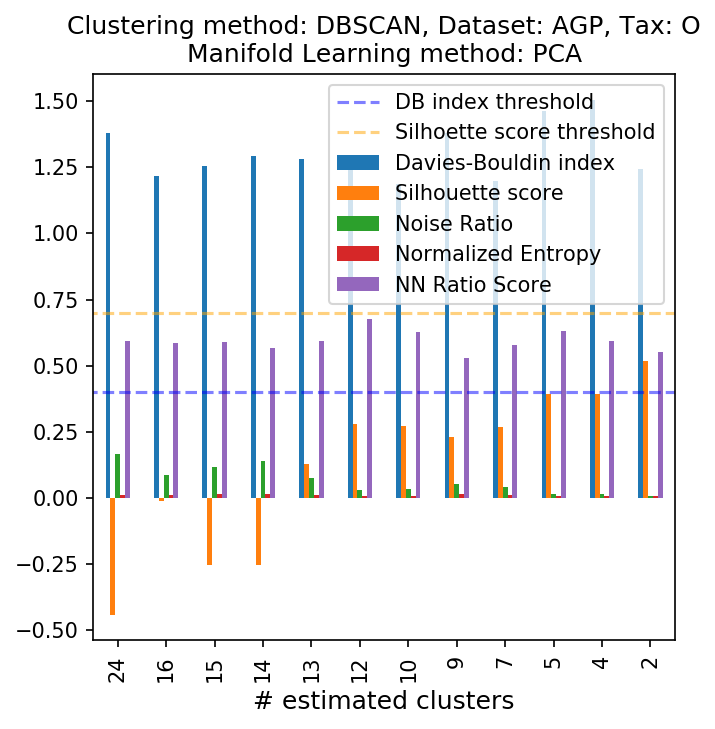

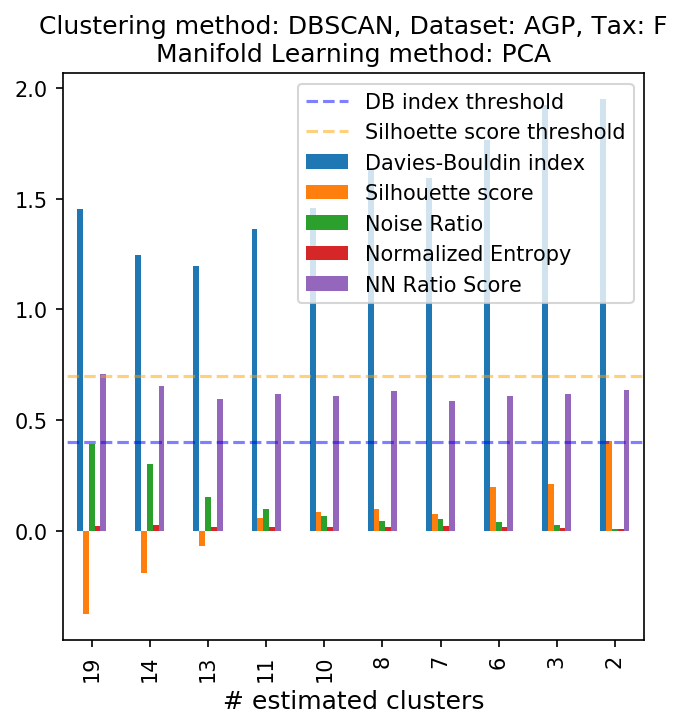

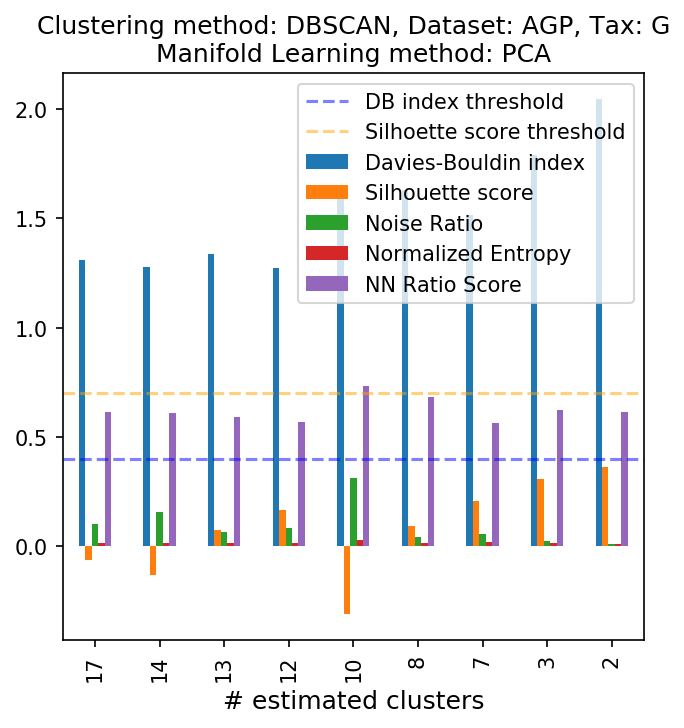

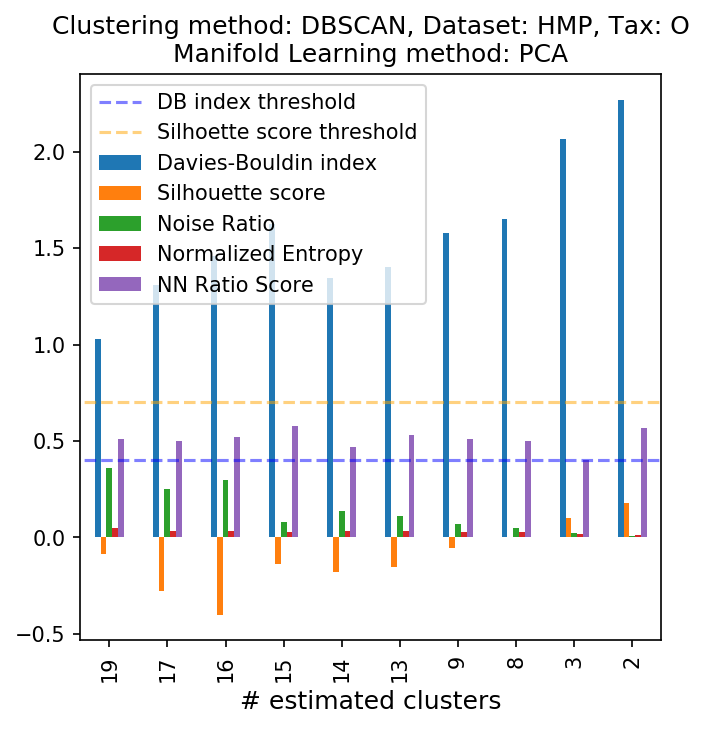

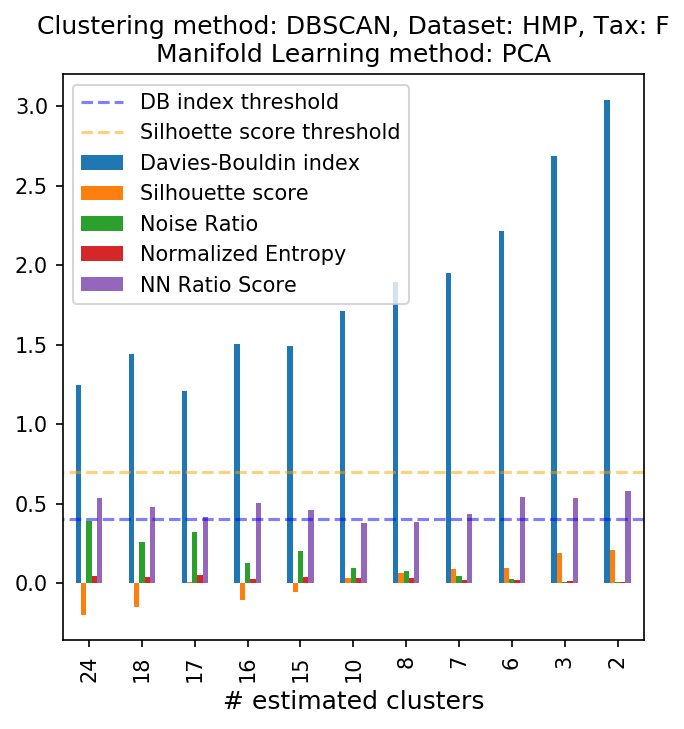

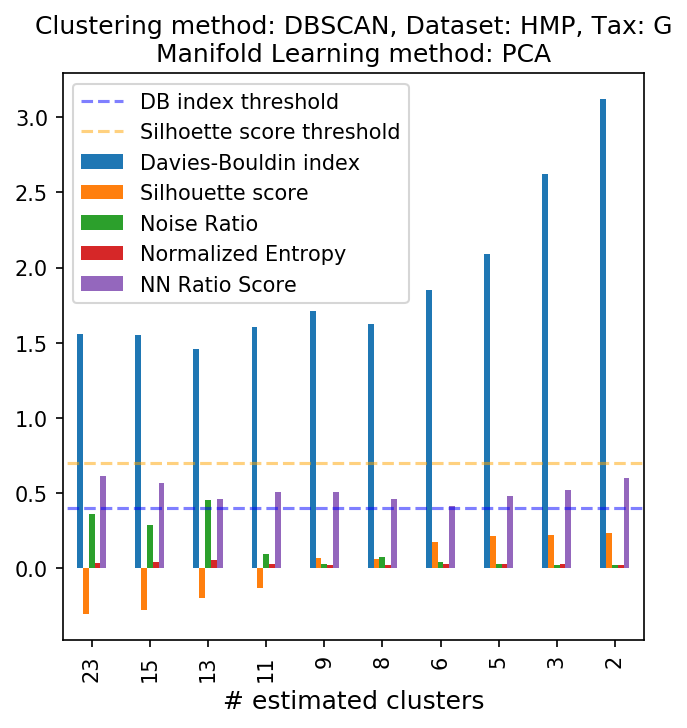

In [33]:
plot_clustering(pca_cluster_results_list[0], method='Manifold Learning method: PCA', suptitle='Clustering method: DBSCAN')

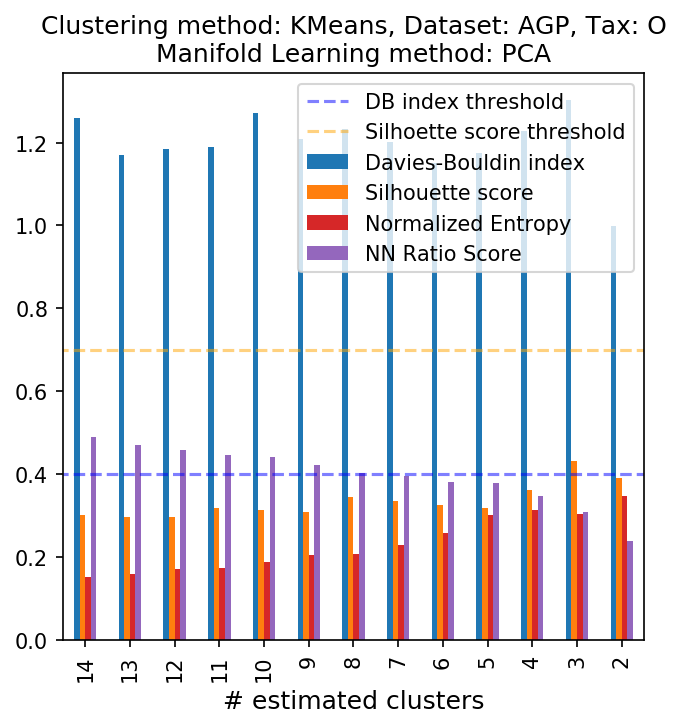

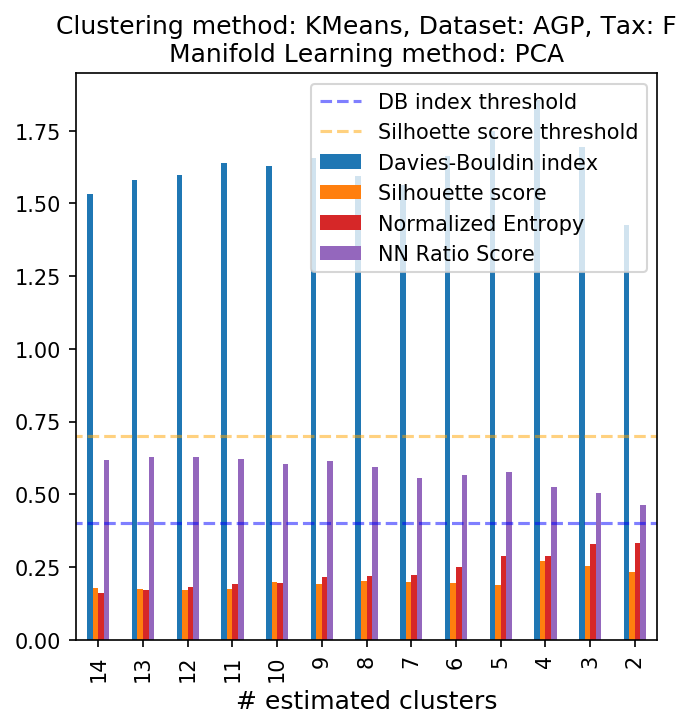

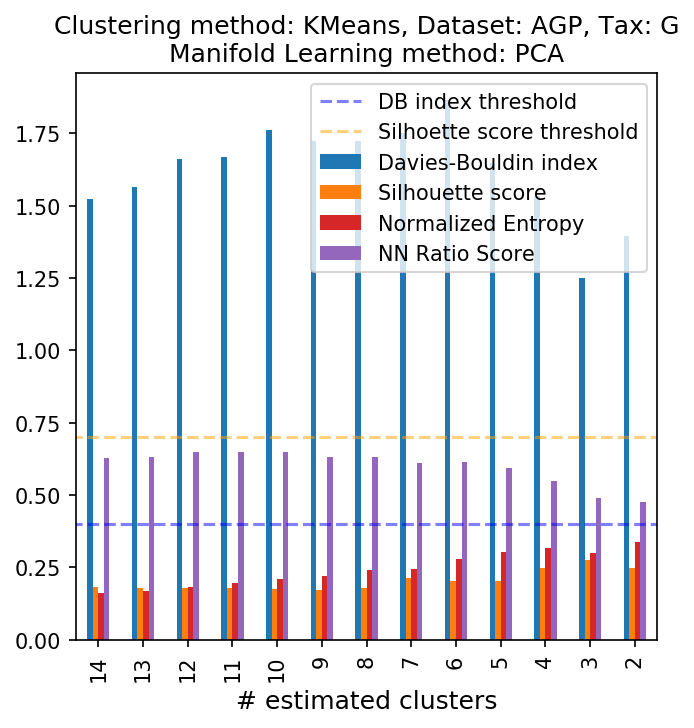

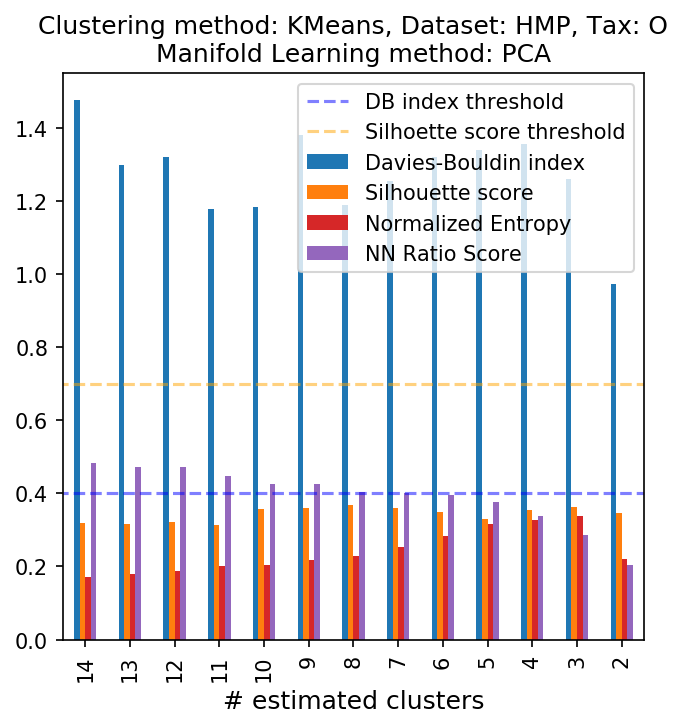

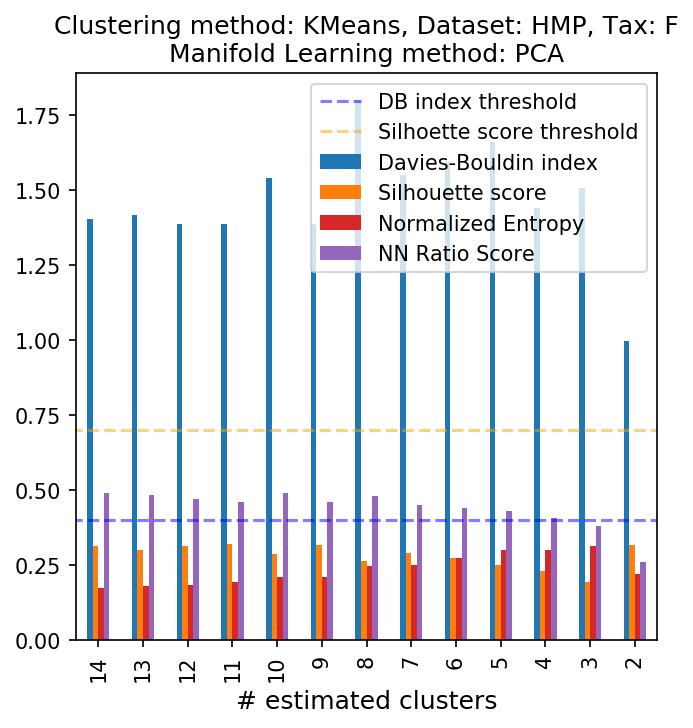

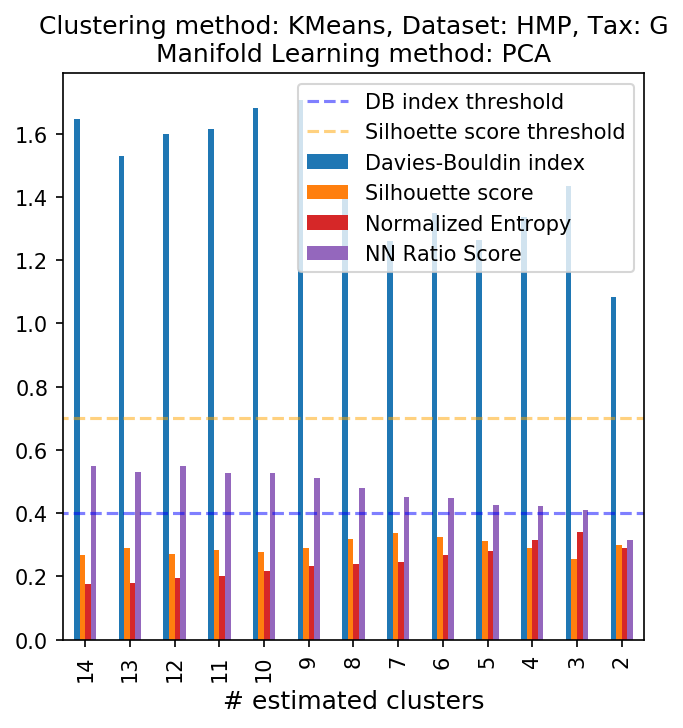

In [34]:
plot_clustering(pca_cluster_results_list[1], method='Manifold Learning method: PCA', suptitle='Clustering method: KMeans')

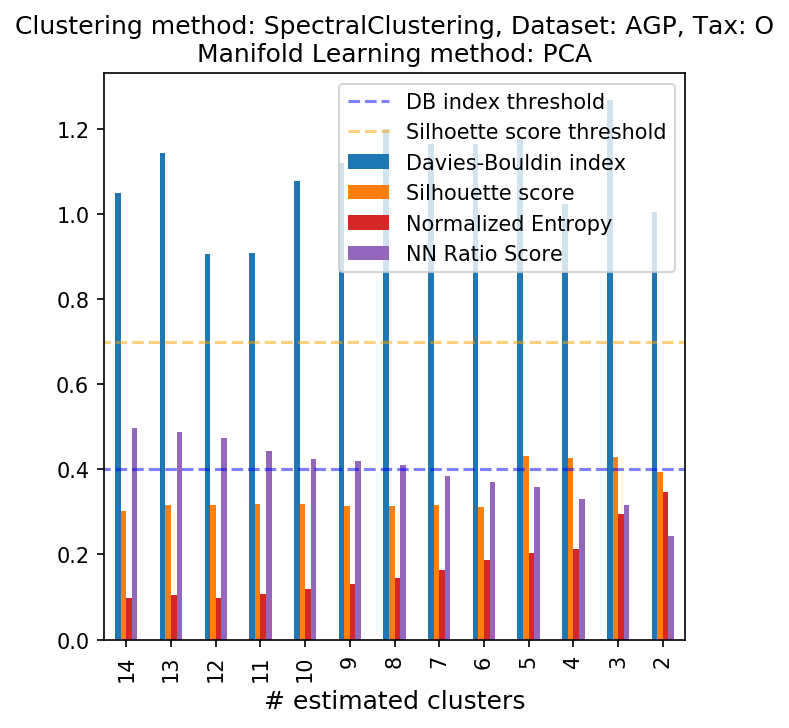

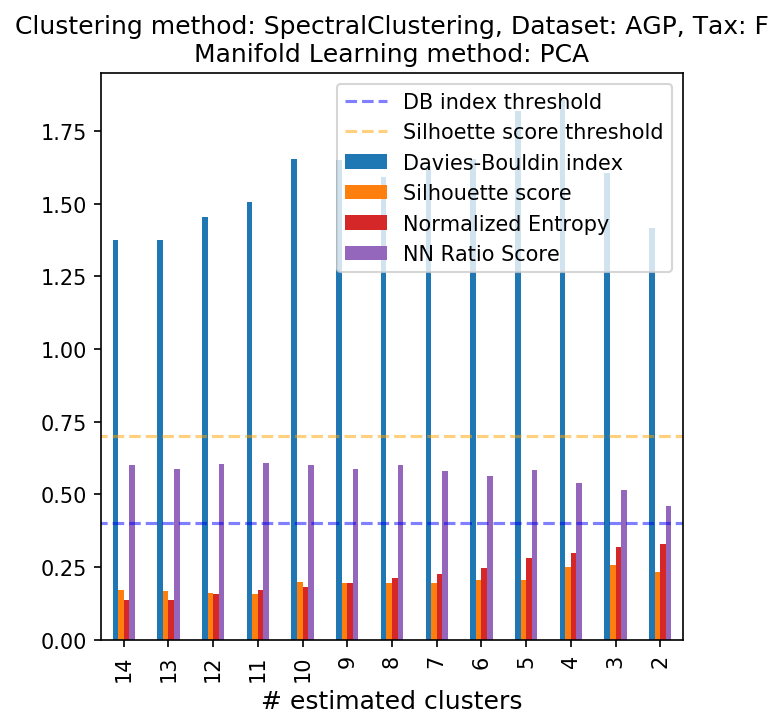

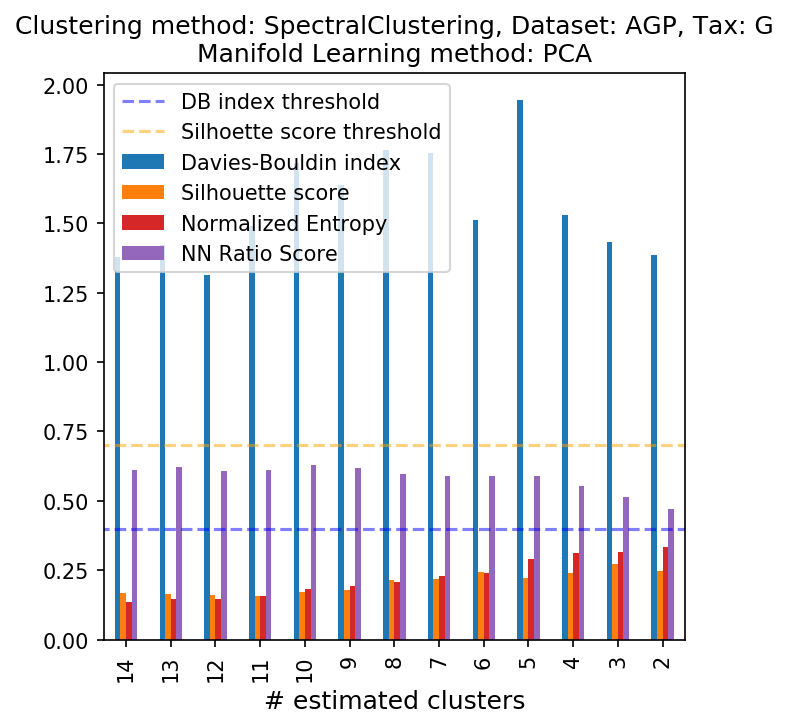

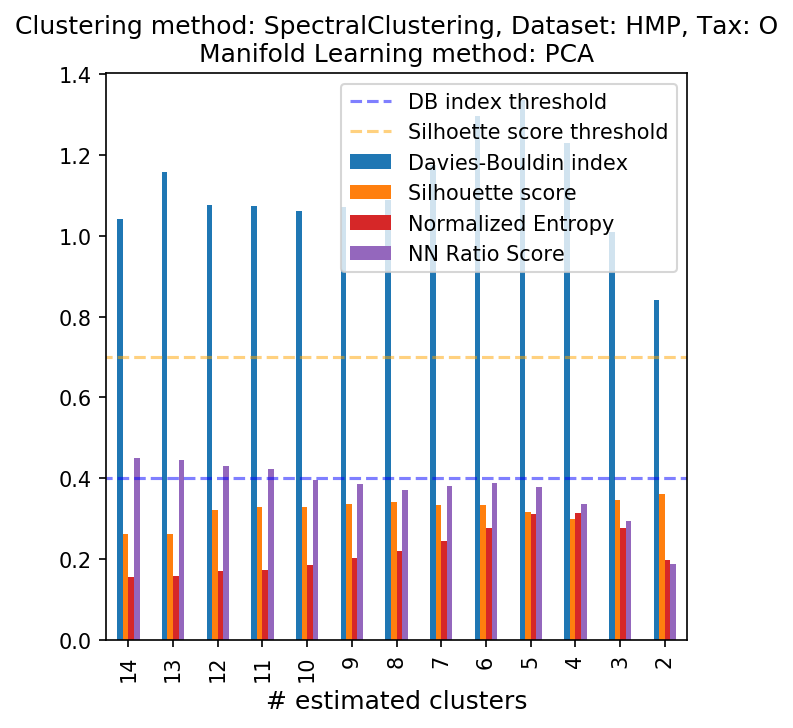

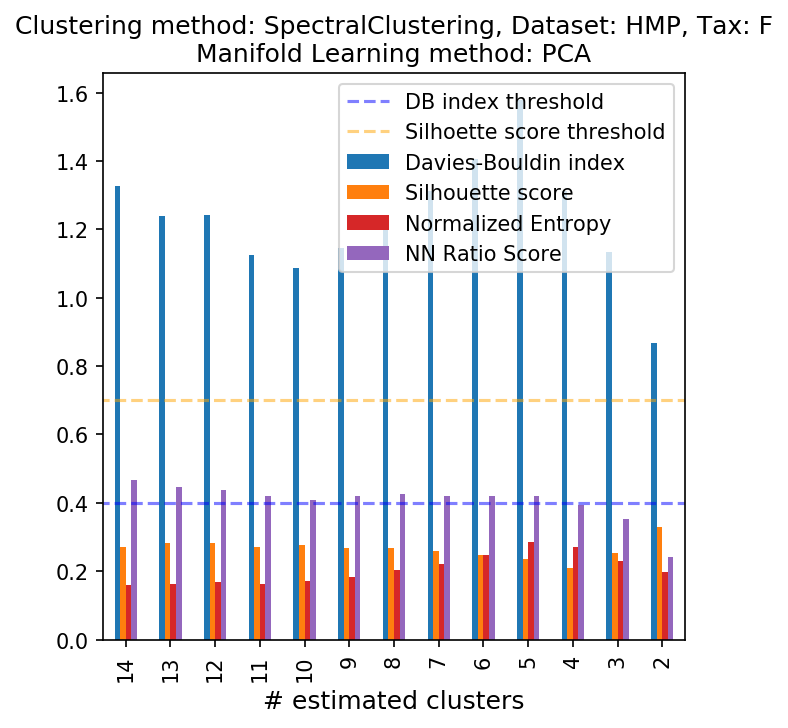

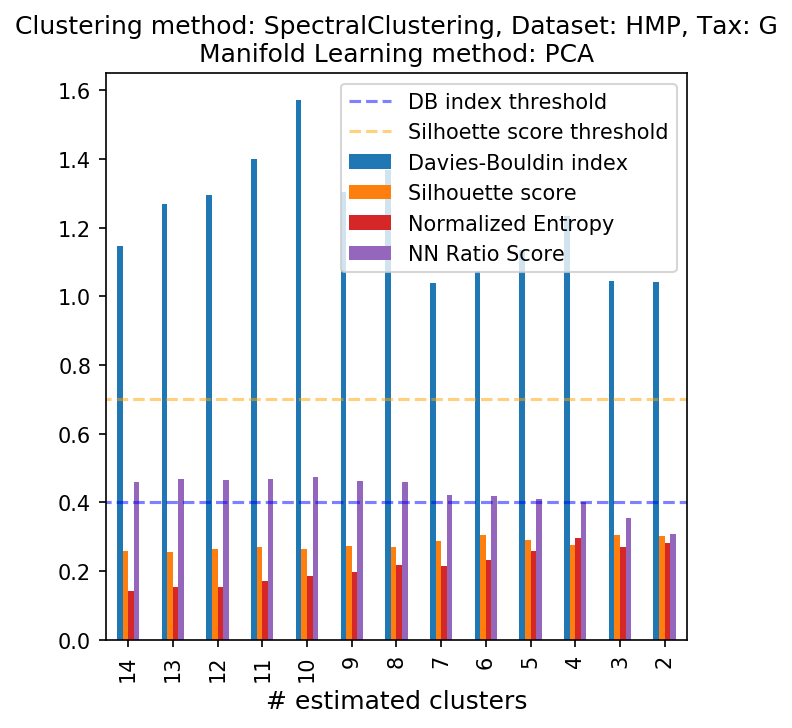

In [35]:
plot_clustering(pca_cluster_results_list[2], method='Manifold Learning method: PCA', suptitle='Clustering method: SpectralClustering')

# AE

In [ ]:
def SpectralClustering_modified(*args):
    return SpectralClustering(*args, n_jobs=-1, eigen_tol=1e-4)

In [ ]:
LABEL2DBSCAN_PARAMS_AE = {}
for (label,data) in data_ae.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_AE[label] = [min(p95_list), max(p95_list)]

In [ ]:
methods_dict_ae = {'dbscan':[DBSCAN, [None]*30],
                   'KMeans':[KMeans, np.arange(2, 15, 1)],
                   'SpectralClustering':[SpectralClustering_modified, np.arange(2, 15, 1)]}

methods_names = list(methods_dict_ae.keys())

ae_cluster_results_list = []
ae_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_ae[method_name]
    cluster_results, cluster_preds = clustering(data_ae, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_AE)
    
    ae_cluster_results_list.append(cluster_results)
    ae_cluster_preds_list.append(cluster_preds)
    
np.save('./clustering_results/ae_cluster_results_list', ae_cluster_results_list)
np.save('./clustering_results/ae_cluster_preds_list', ae_cluster_preds_list)

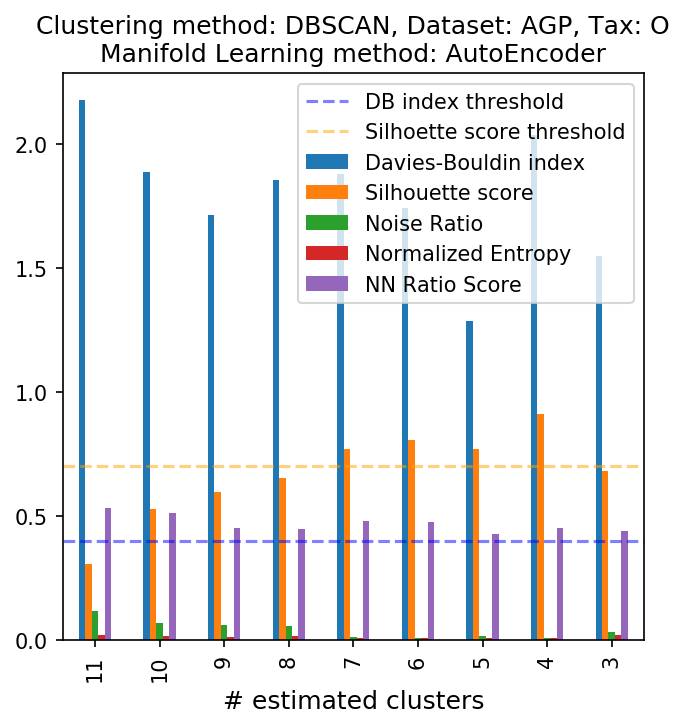

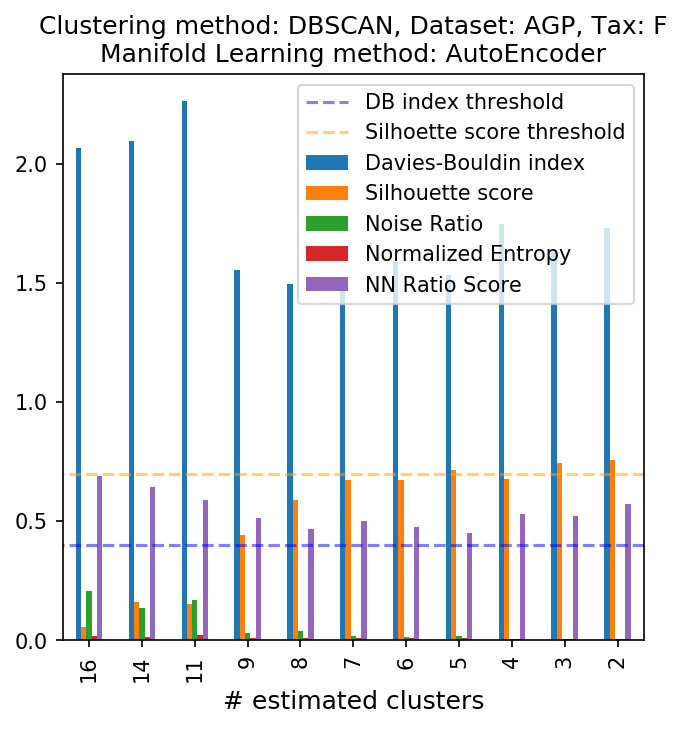

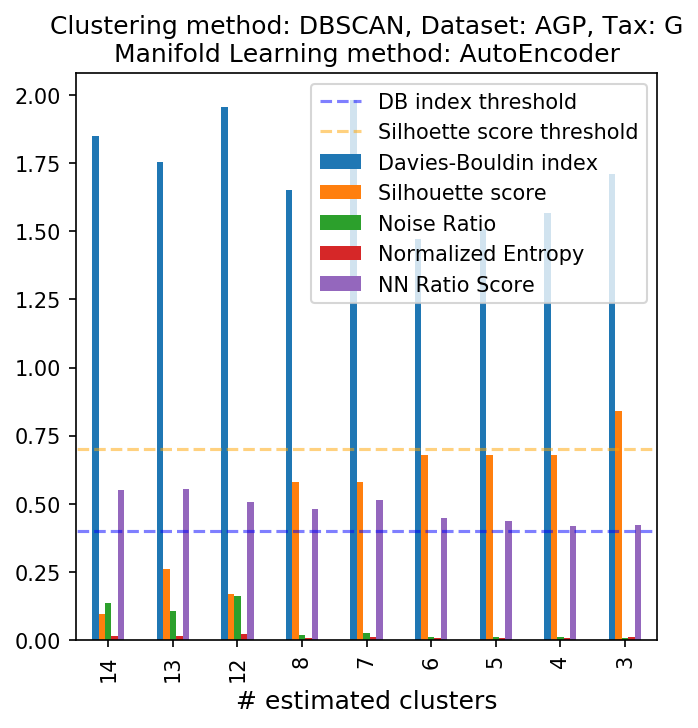

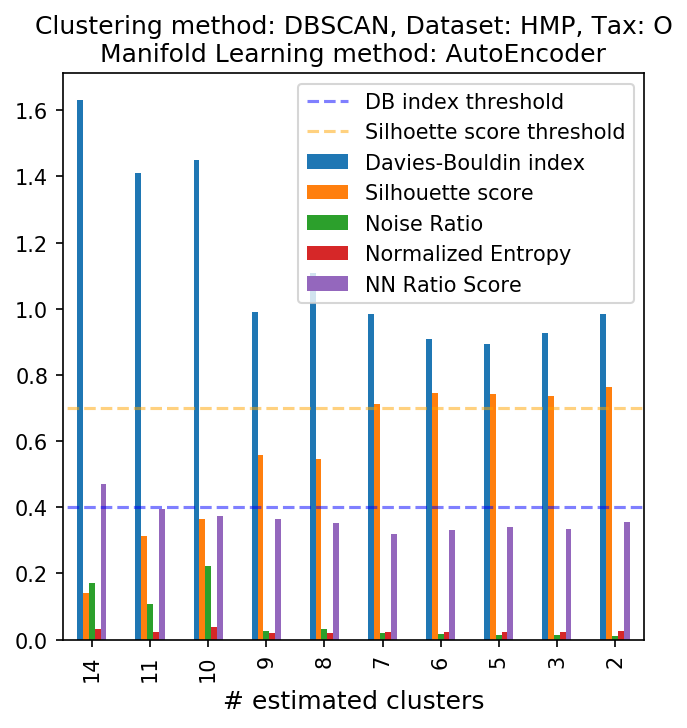

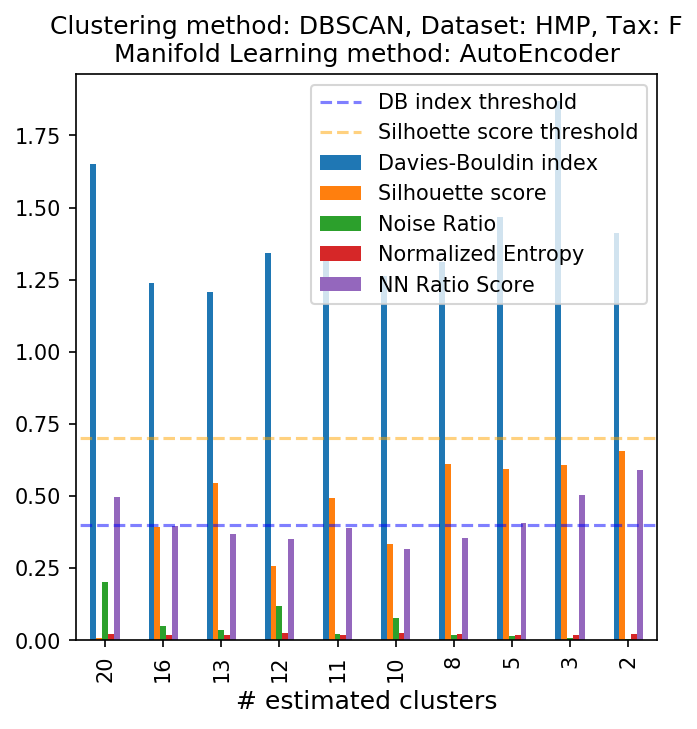

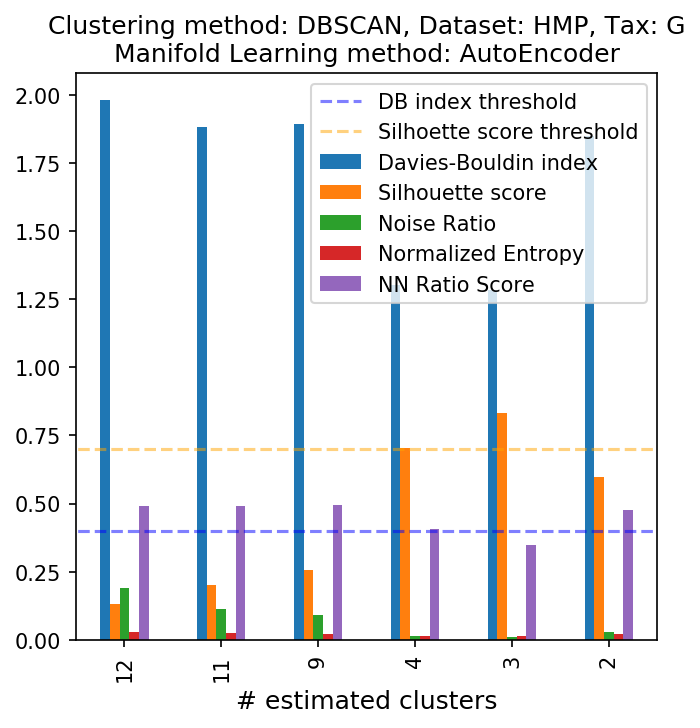

In [36]:
plot_clustering(ae_cluster_results_list[0], method='Manifold Learning method: AutoEncoder', suptitle='Clustering method: DBSCAN')

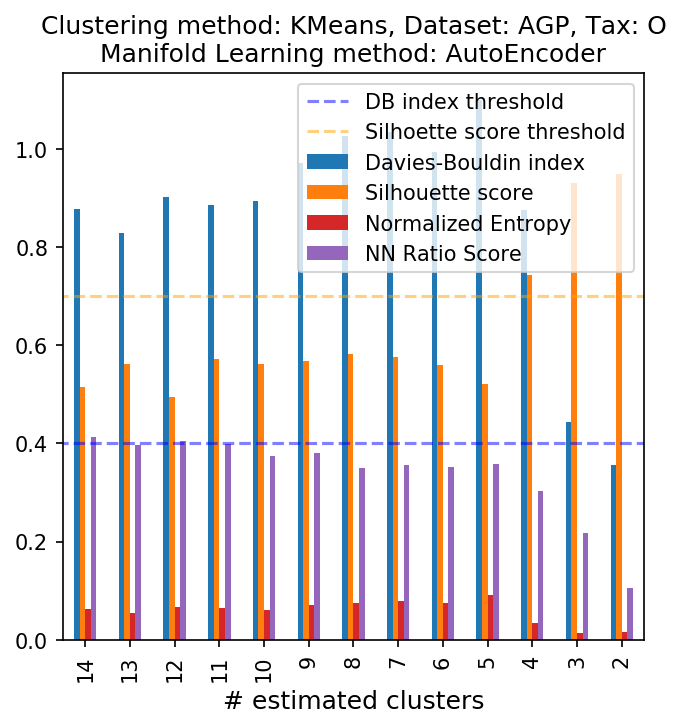

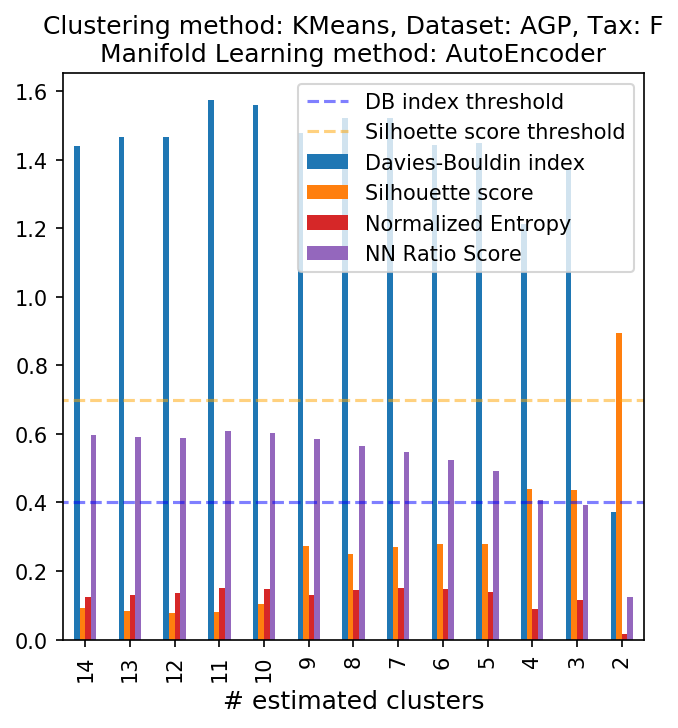

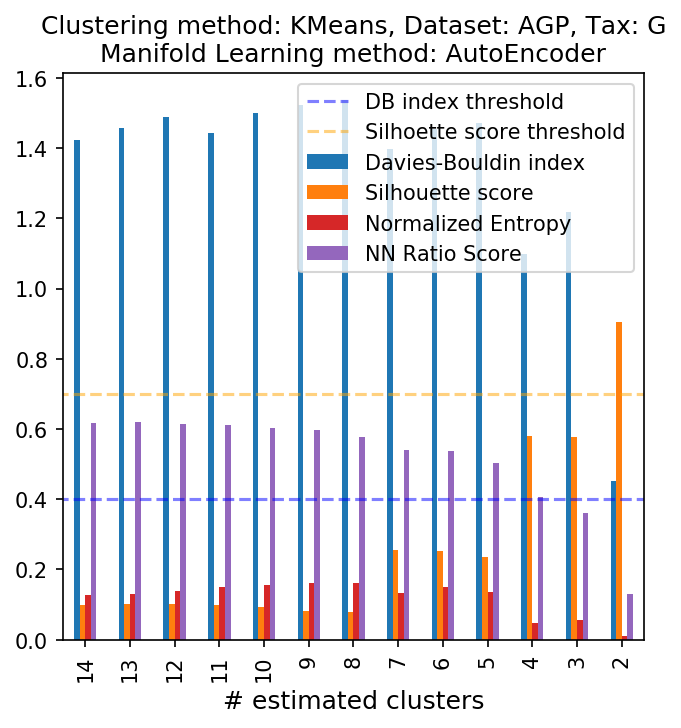

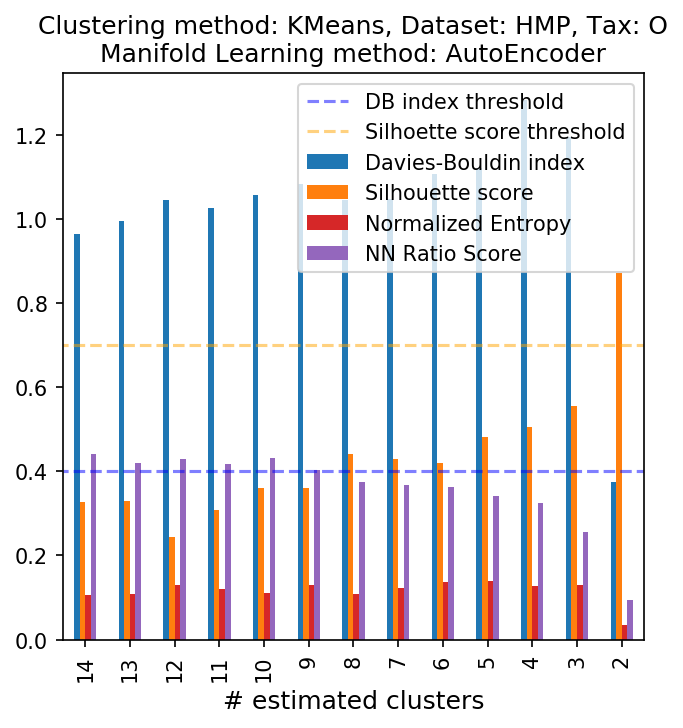

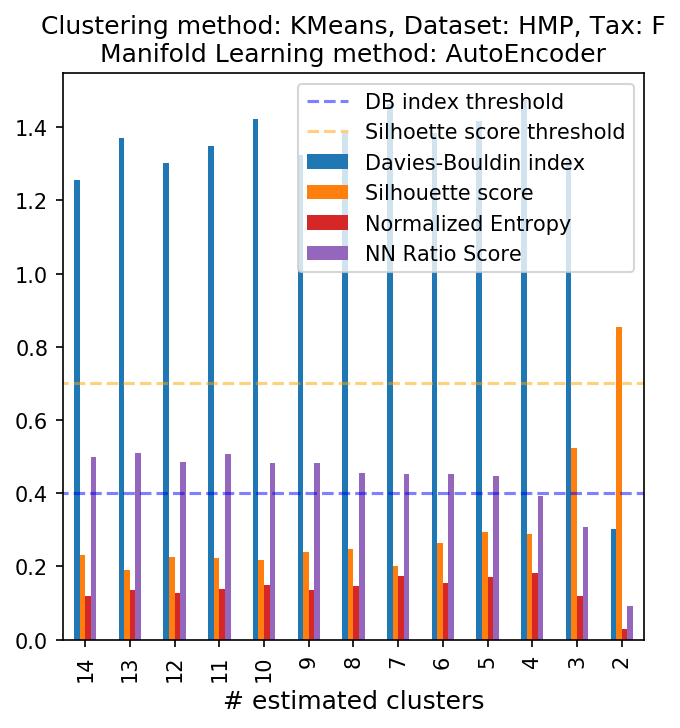

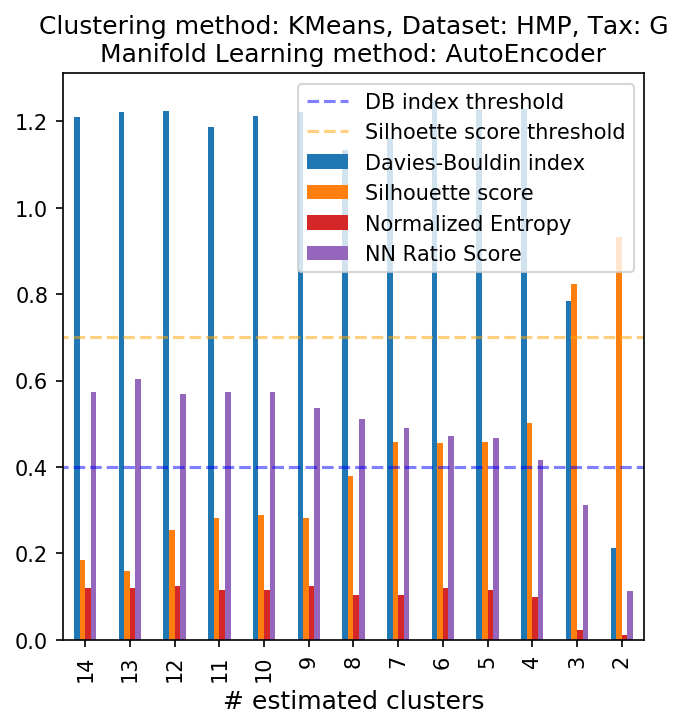

In [37]:
plot_clustering(ae_cluster_results_list[1], method='Manifold Learning method: AutoEncoder', suptitle='Clustering method: KMeans')

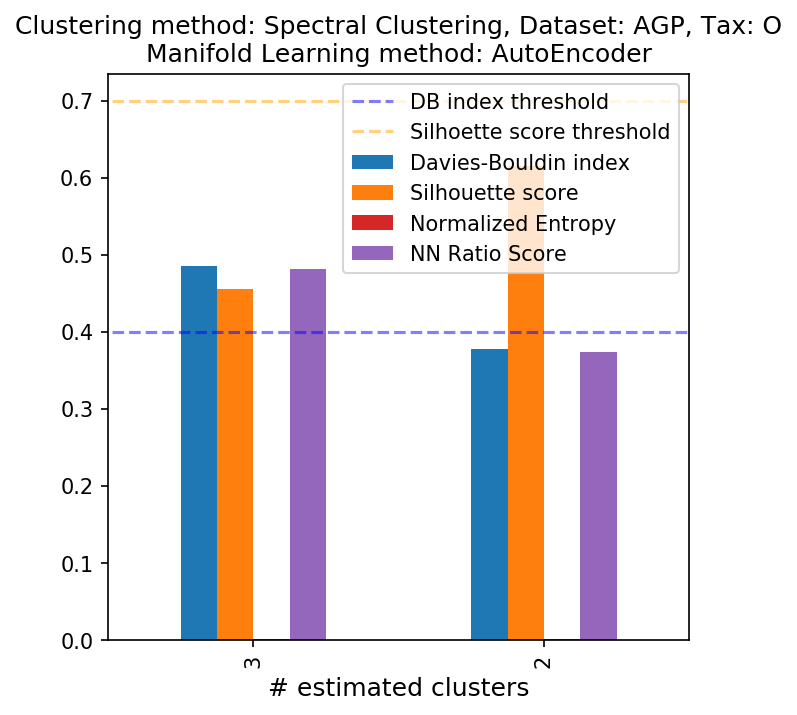

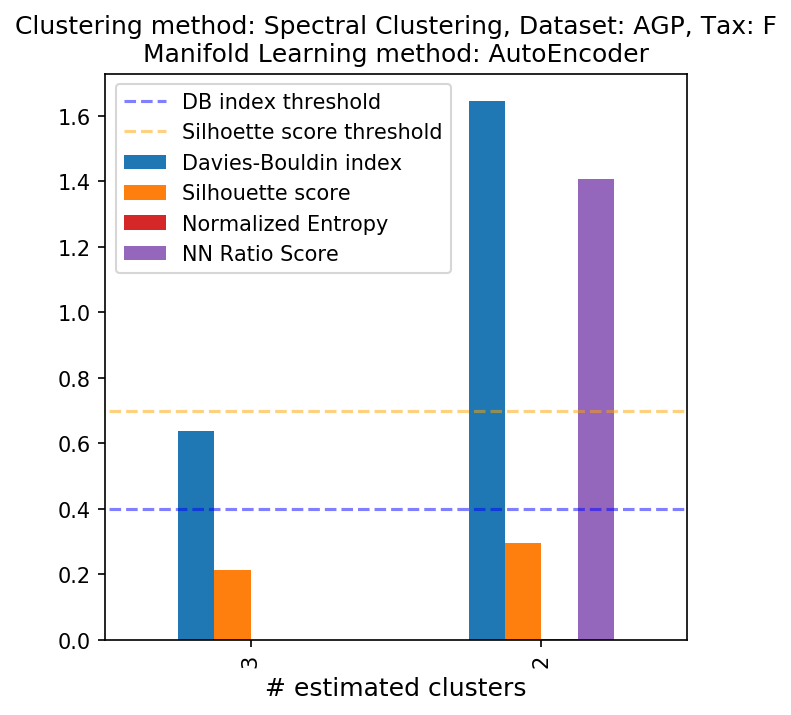

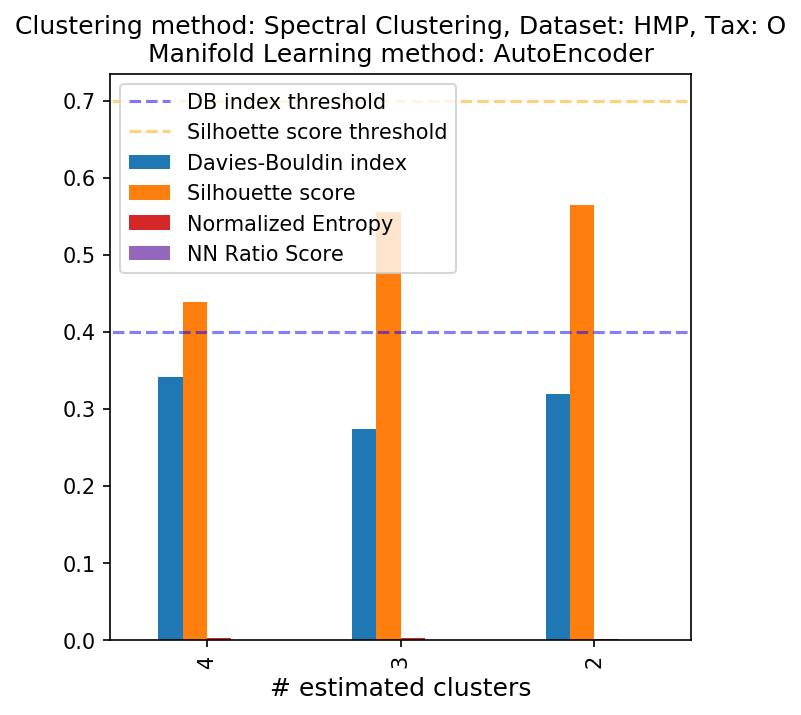

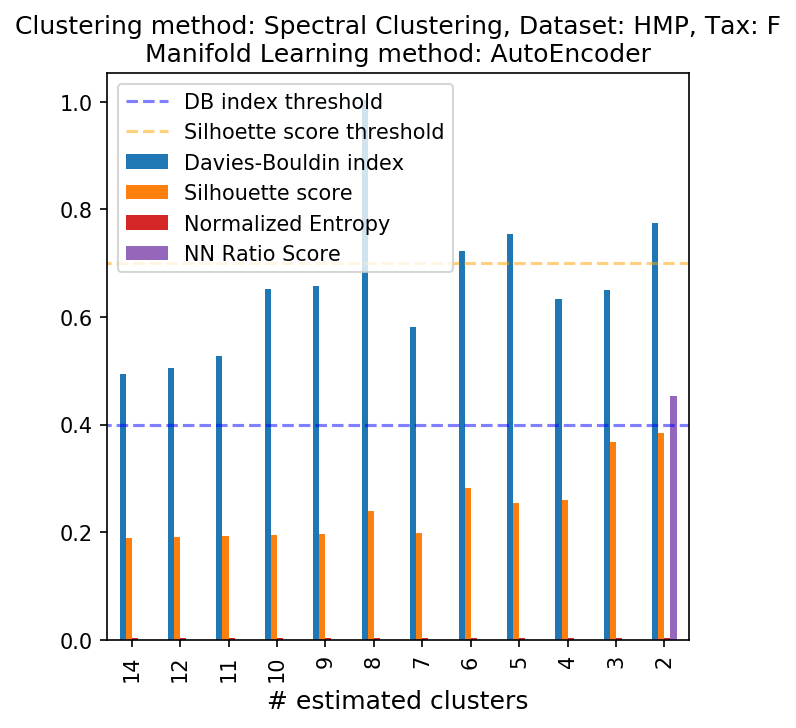

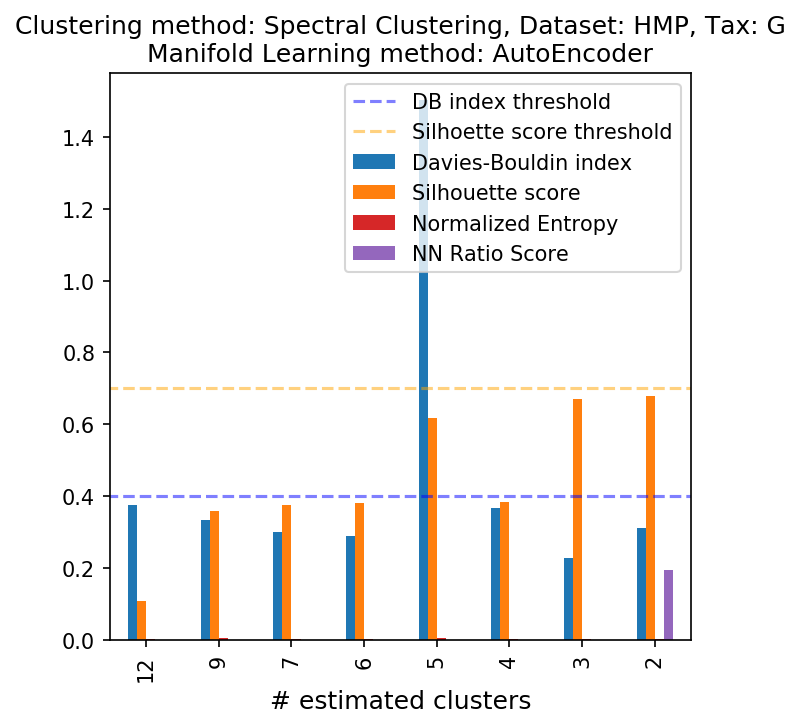

In [39]:
plot_clustering(ae_cluster_results_list[2], method='Manifold Learning method: AutoEncoder', suptitle='Clustering method: Spectral Clustering')

In [ ]:
# DISTINCT_CLUSTERS_RESULTS_AE = {'AGP_proj_o':{'DBSCAN':[ae_cluster_preds_list[0]['AGP_proj_o'], 5]}}
# plot_results(DISTINCT_CLUSTERS_RESULTS_AE, data_ae)

In [ ]:
DISTINCT_CLUSTERS_RESULTS_AE = {'AGP_proj_o':{'KMeans':[ae_cluster_preds_list[1]['AGP_proj_o'], 2]}}
plot_results(DISTINCT_CLUSTERS_RESULTS_AE, data_ae, 'AutoEncoder')

# Isomap

In [ ]:
LABEL2DBSCAN_PARAMS_ISOMAP = {}
for (label,data) in data_isomap.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_ISOMAP[label] = [min(p95_list), max(p95_list)]

In [ ]:
methods_dict_isomap = {'dbscan':[DBSCAN, [None]*30],
                       'KMeans':[KMeans, np.arange(2, 15, 1)],
                       'SpectralClustering':[SpectralClustering_modified, np.arange(2, 15, 1)]}

methods_names = list(methods_dict_isomap.keys())

isomap_cluster_results_list = []
isomap_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_isomap[method_name]
    cluster_results, cluster_preds = clustering(data_isomap, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_ISOMAP)
    
    isomap_cluster_results_list.append(cluster_results)
    isomap_cluster_preds_list.append(cluster_preds)
    
np.save('./clustering_results/isomap_cluster_results_list', isomap_cluster_results_list)
np.save('./clustering_results/isomap_cluster_preds_list', isomap_cluster_preds_list)

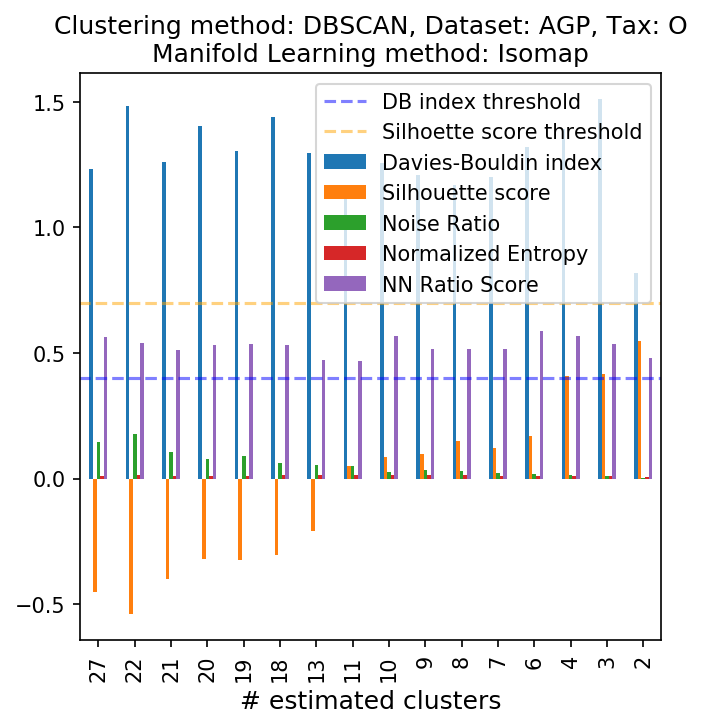

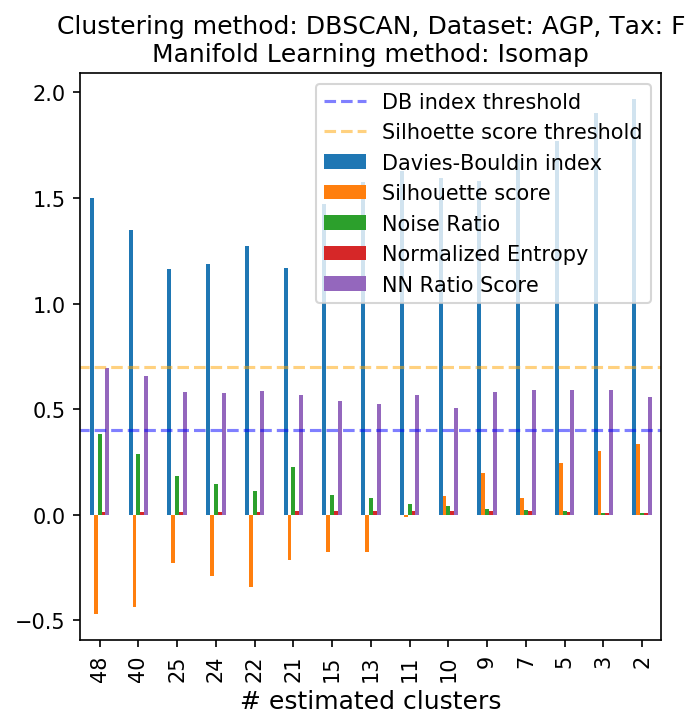

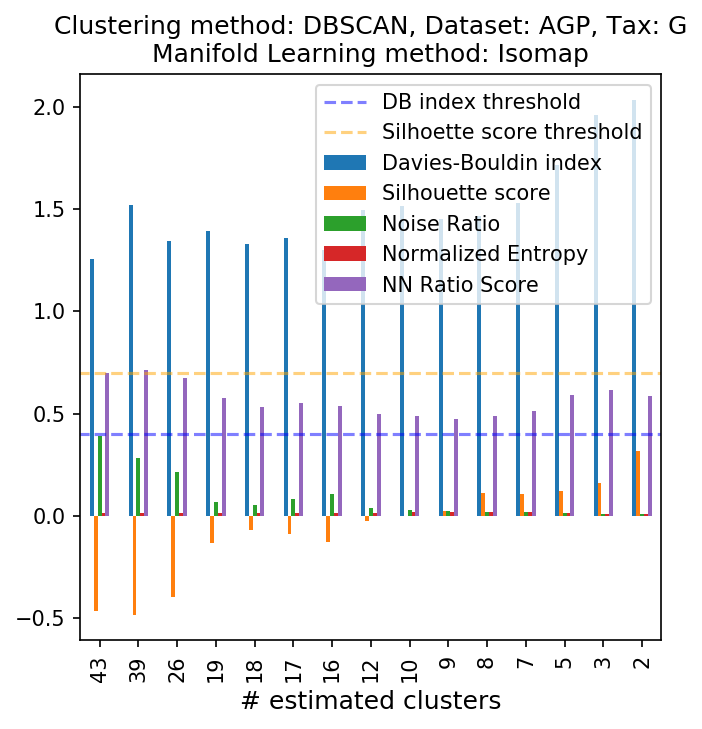

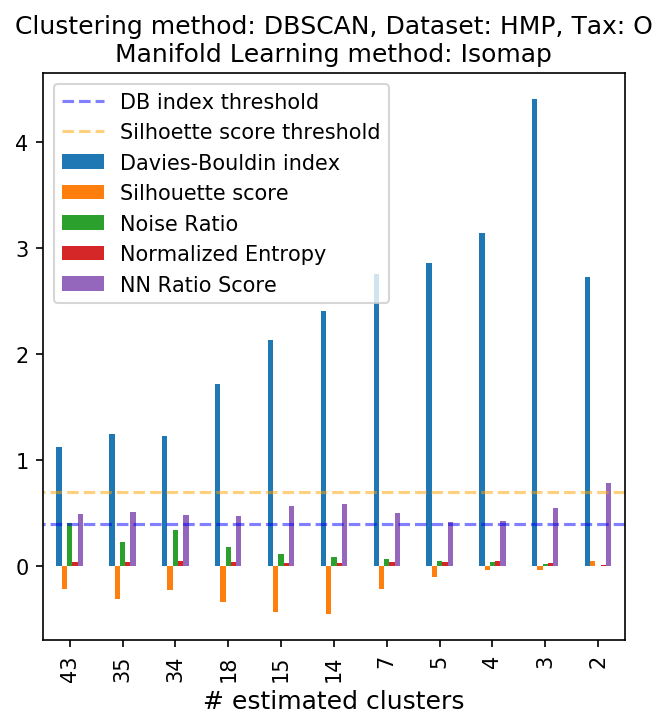

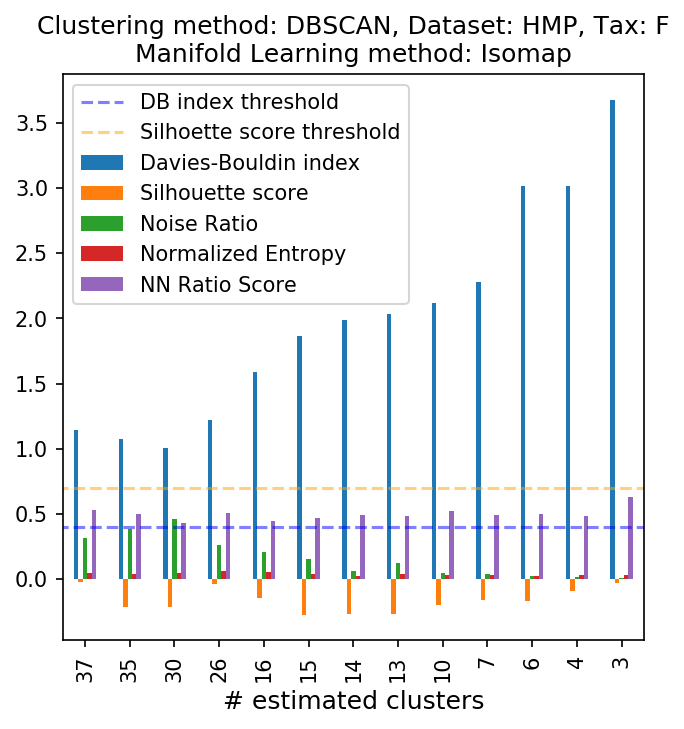

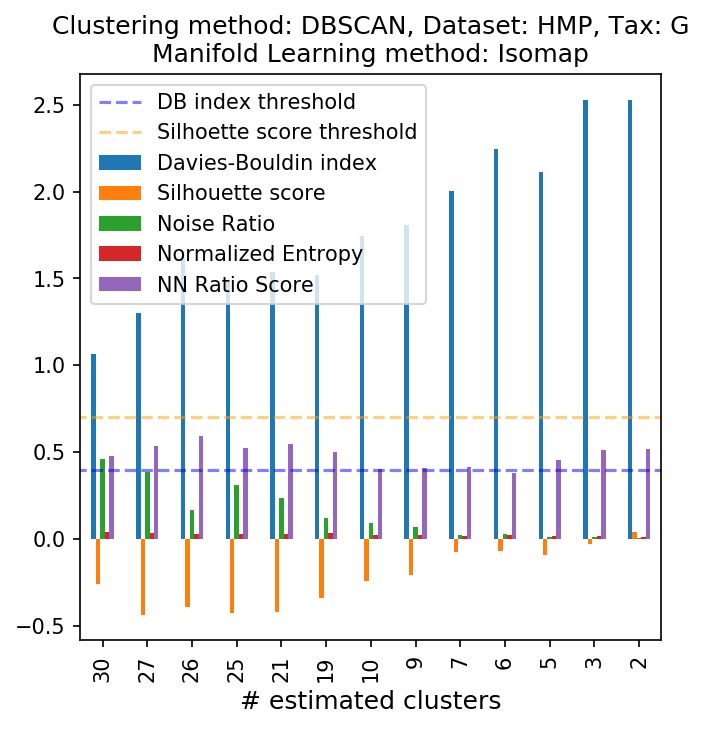

In [43]:
plot_clustering(isomap_cluster_results_list[0], method='Manifold Learning method: Isomap', suptitle='Clustering method: DBSCAN')

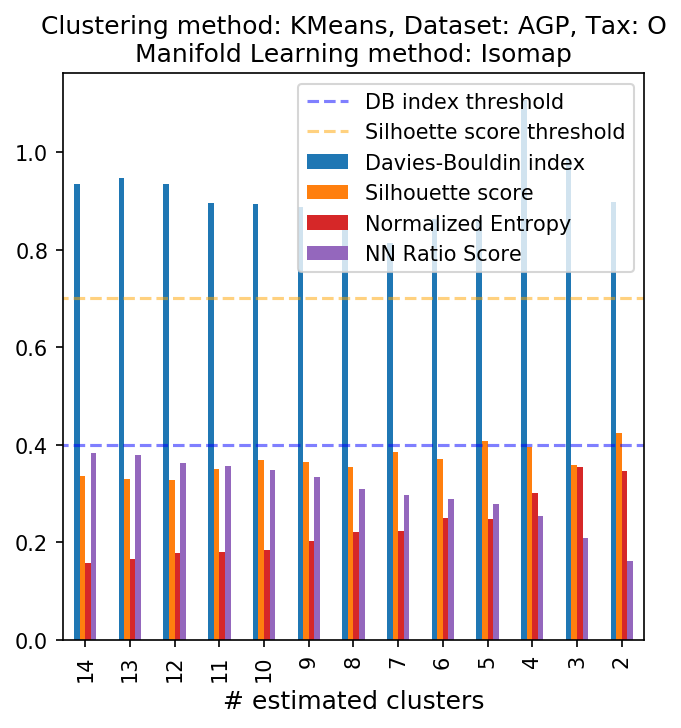

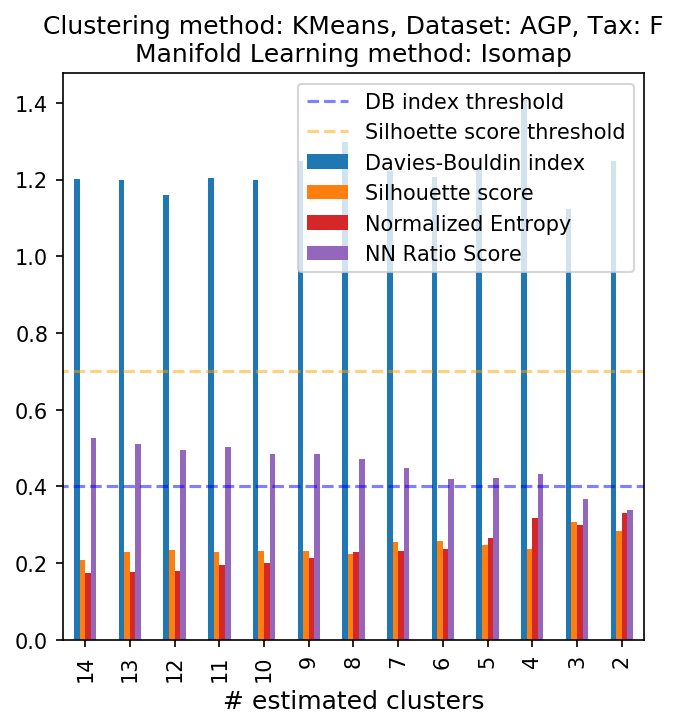

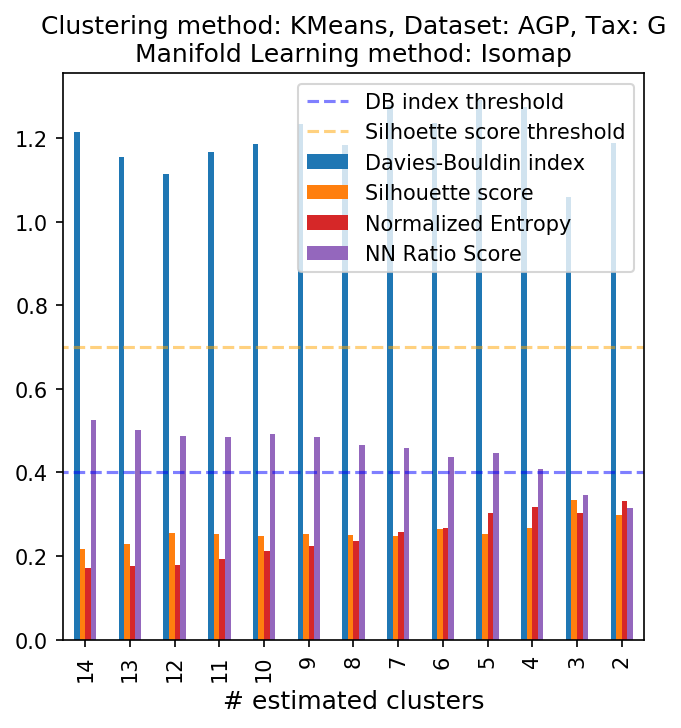

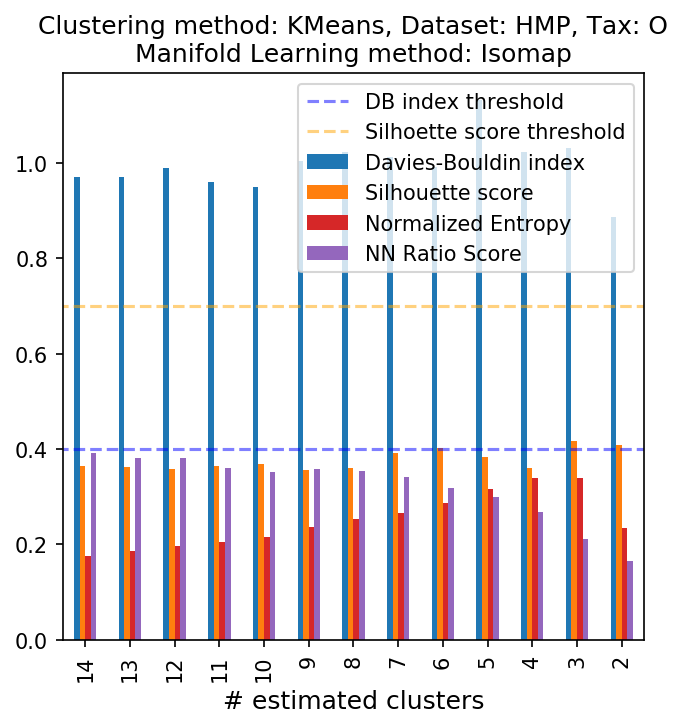

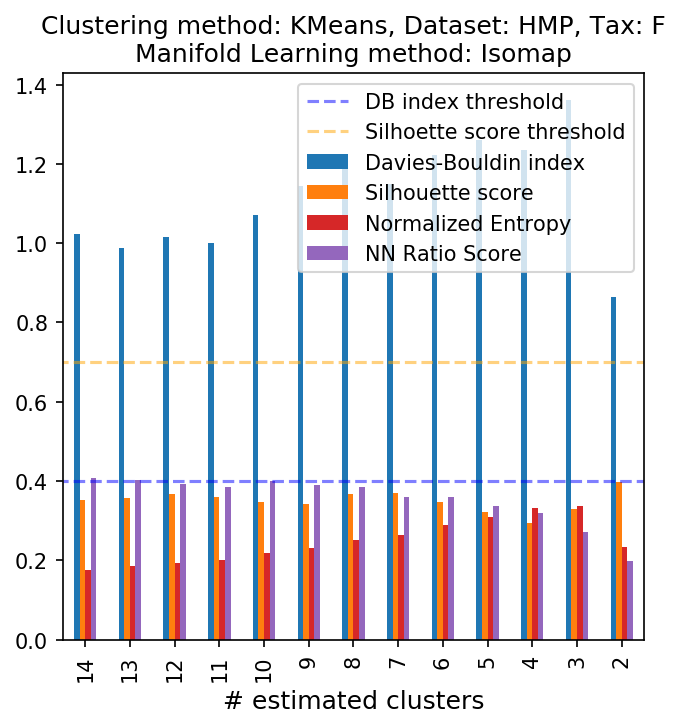

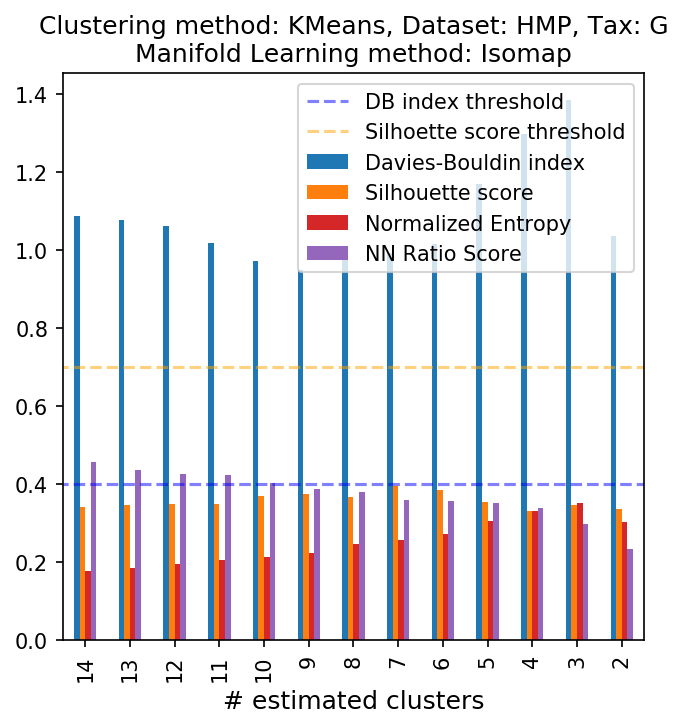

In [44]:
plot_clustering(isomap_cluster_results_list[1], method='Manifold Learning method: Isomap', suptitle='Clustering method: KMeans')

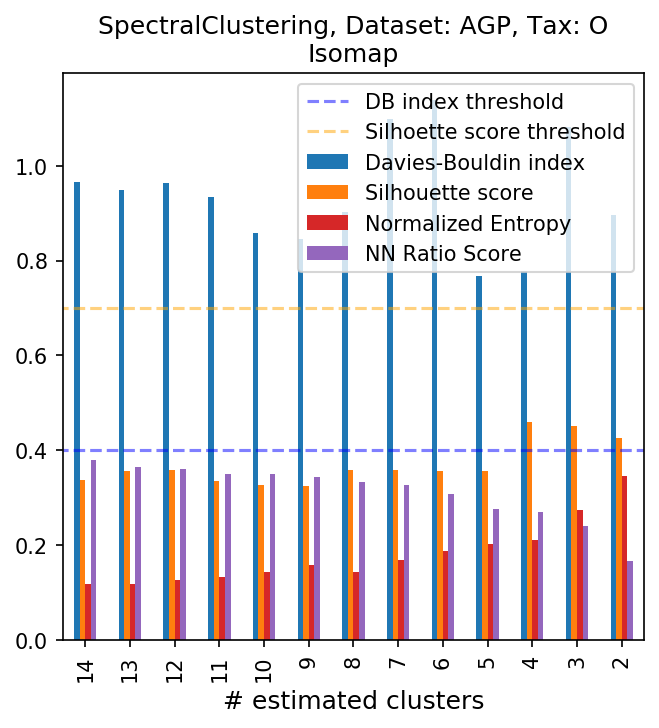

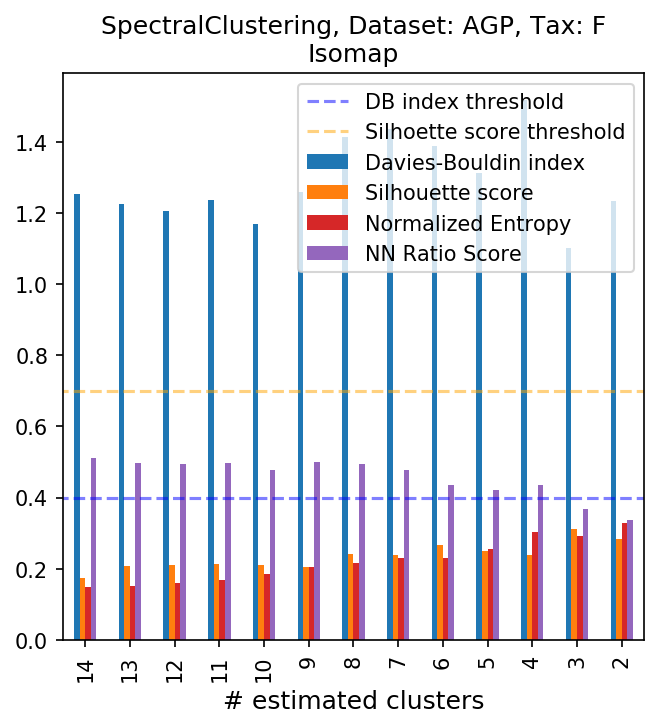

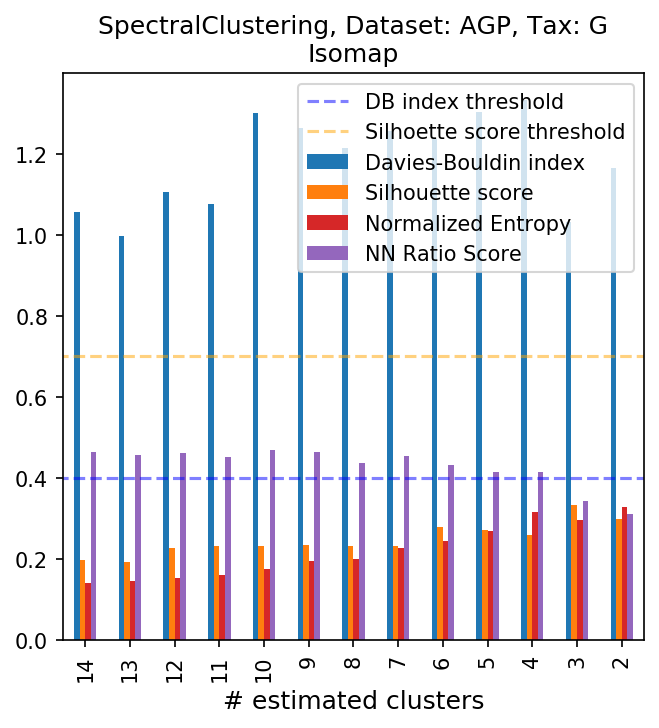

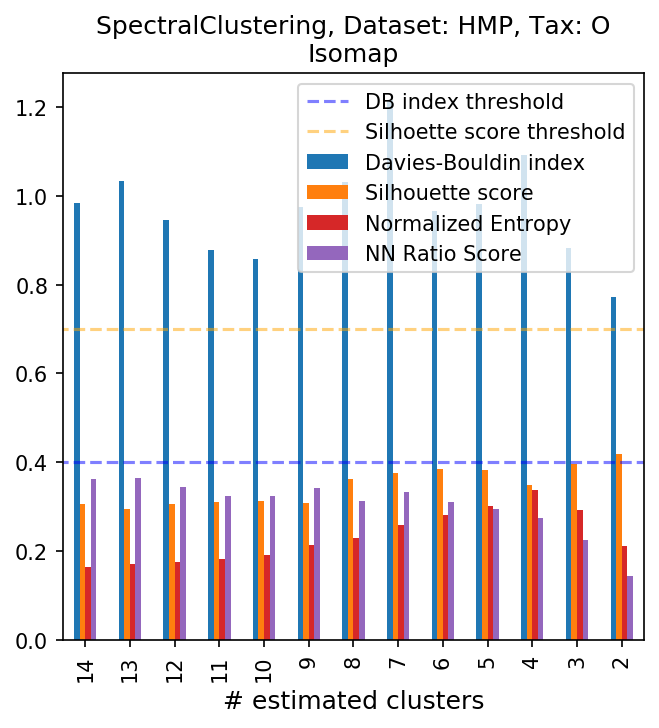

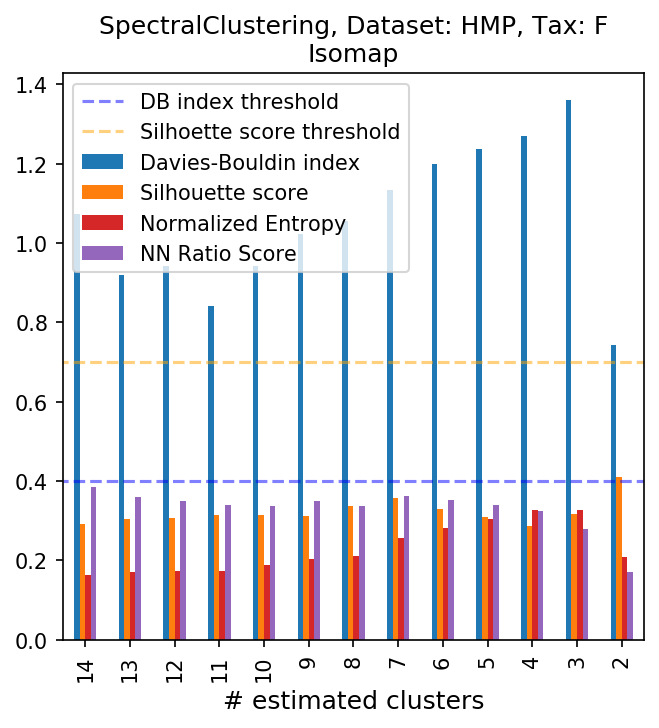

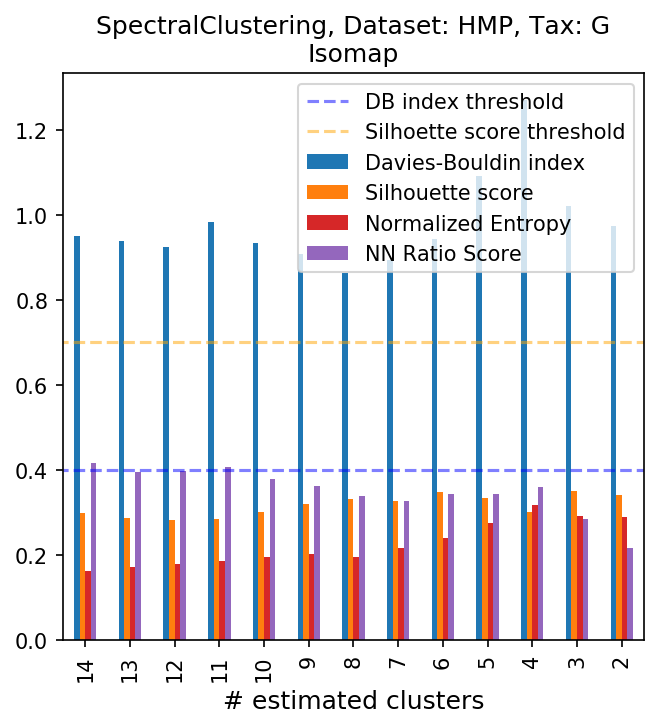

In [45]:
plot_clustering(isomap_cluster_results_list[2], method='Isomap', suptitle='SpectralClustering')

In [46]:
# DISTINCT_CLUSTERS_RESULTS_ISOMAP = {'AGP_proj_o':{'KMeans':[isomap_cluster_preds_list[1]['AGP_proj_o'], 2]}}
# plot_results(DISTINCT_CLUSTERS_RESULTS_ISOMAP, data_isomap, 'Isomap')

# LLE

In [ ]:
LABEL2DBSCAN_PARAMS_LLE = {}
for label,data in data_lle.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_LLE[label] = [min(p95_list), max(p95_list)]

In [ ]:
methods_dict_lle = {'dbscan':[DBSCAN, [None]*30],
                    'KMeans':[KMeans, np.arange(2, 15, 1)],
                    'SpectralClustering':[SpectralClustering_modified, np.arange(2, 15, 1)]}

methods_names = list(methods_dict_lle.keys())

lle_cluster_results_list = []
lle_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_lle[method_name]
    cluster_results, cluster_preds = clustering(data_lle, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_LLE)
    
    lle_cluster_results_list.append(cluster_results)
    lle_cluster_preds_list.append(cluster_preds)
    
np.save('./clustering_results/lle_cluster_results_list', lle_cluster_results_list)
np.save('./clustering_results/lle_cluster_preds_list', lle_cluster_preds_list)

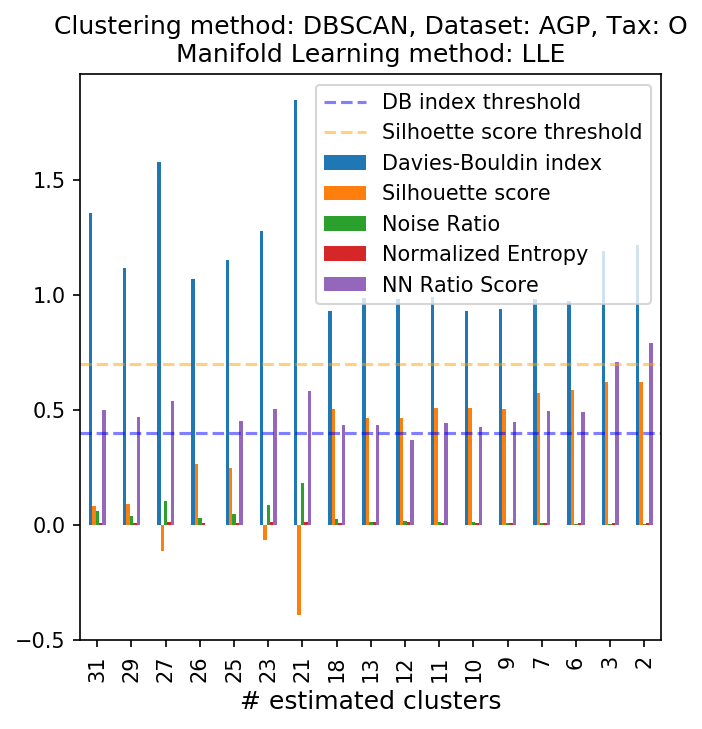

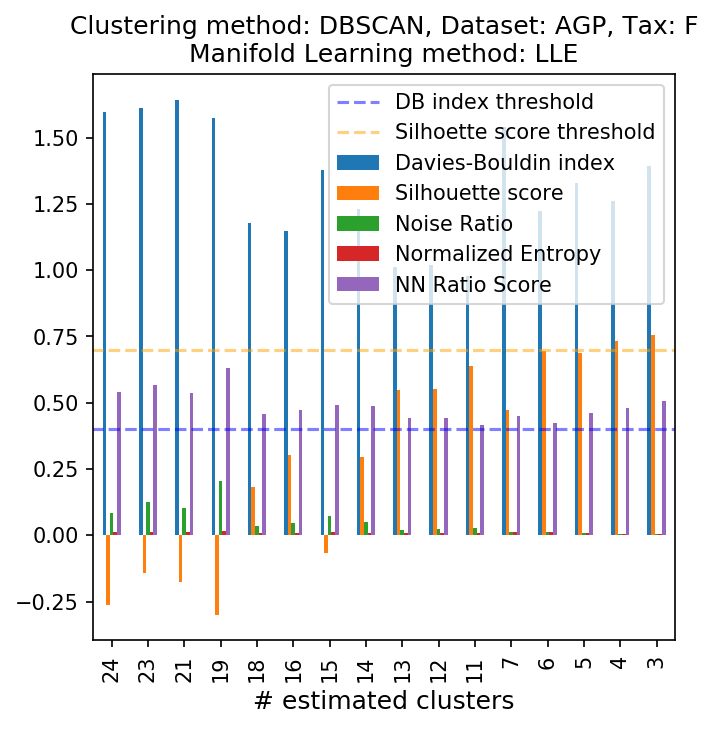

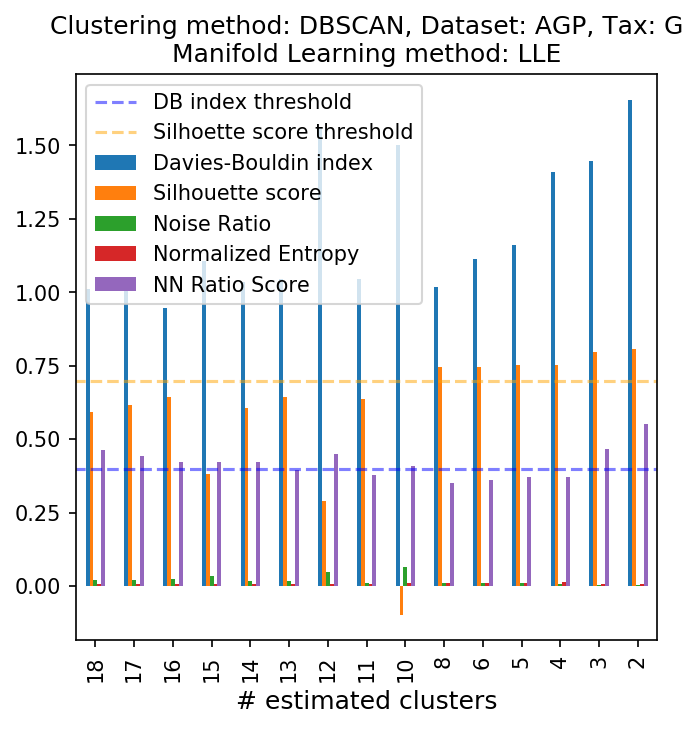

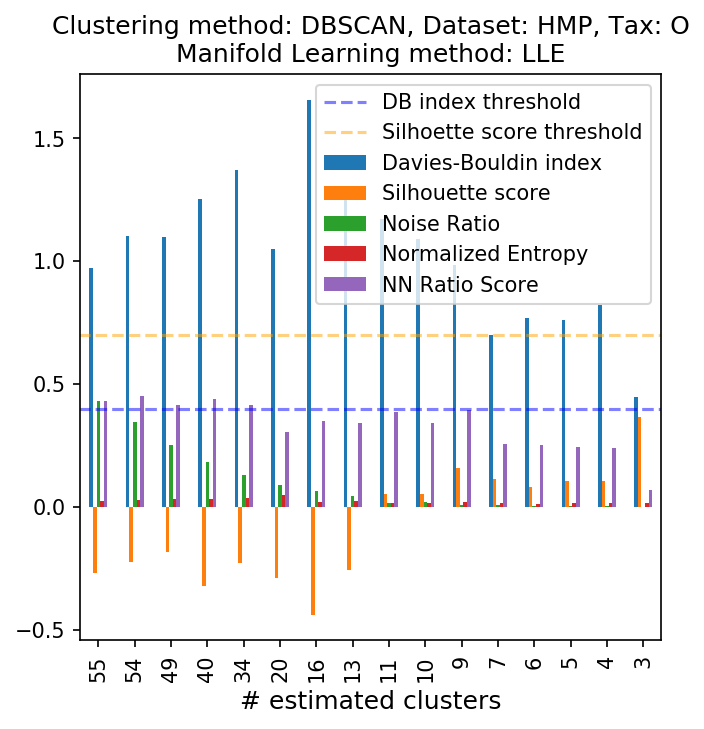

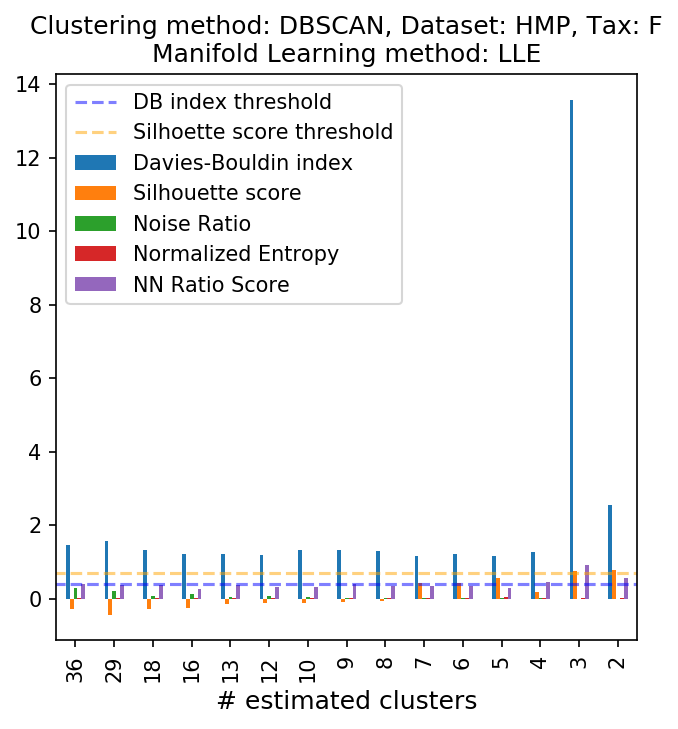

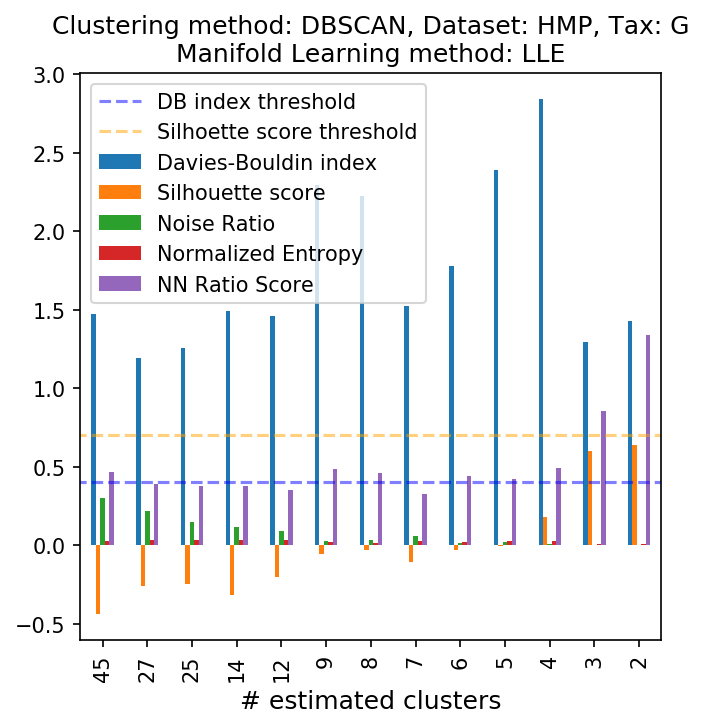

In [47]:
plot_clustering(lle_cluster_results_list[0], method='Manifold Learning method: LLE', suptitle='Clustering method: DBSCAN')

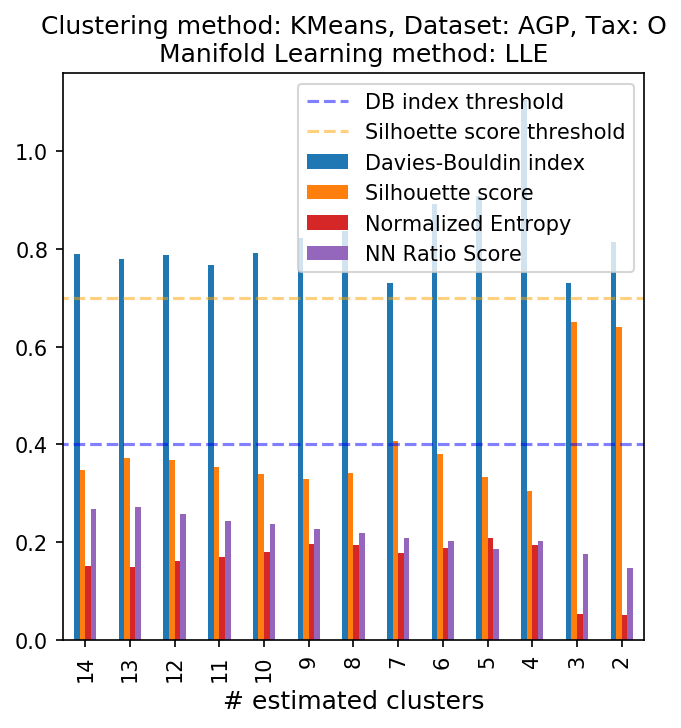

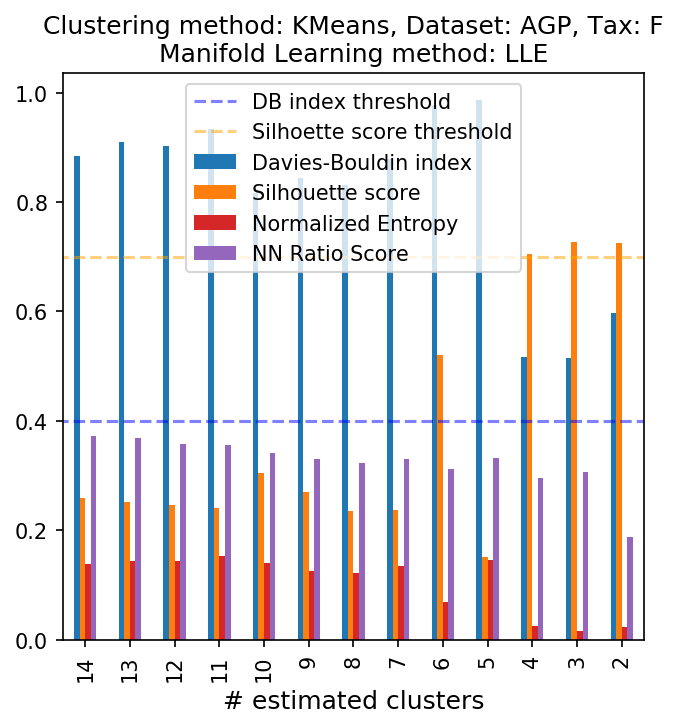

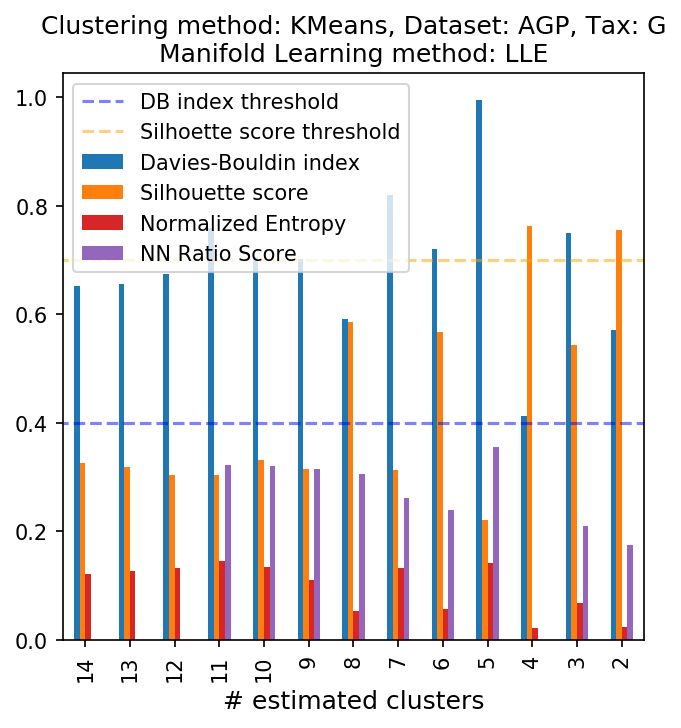

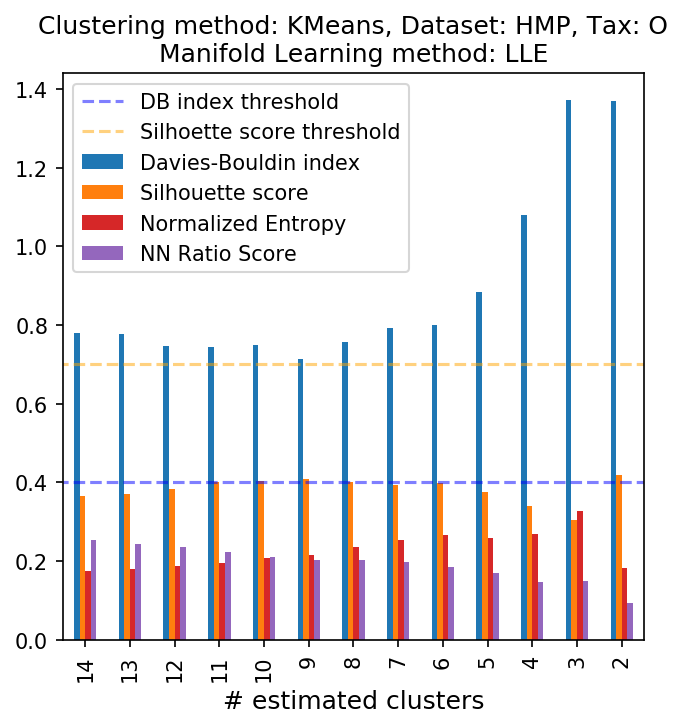

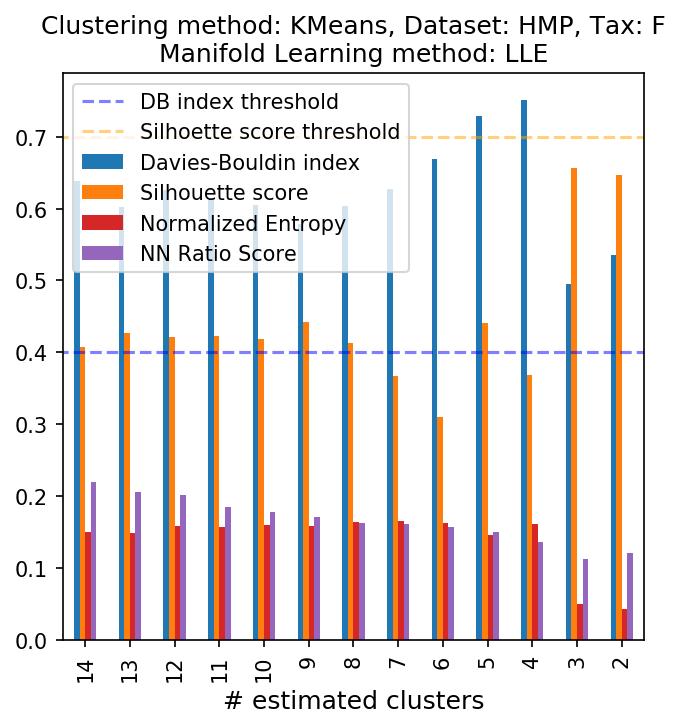

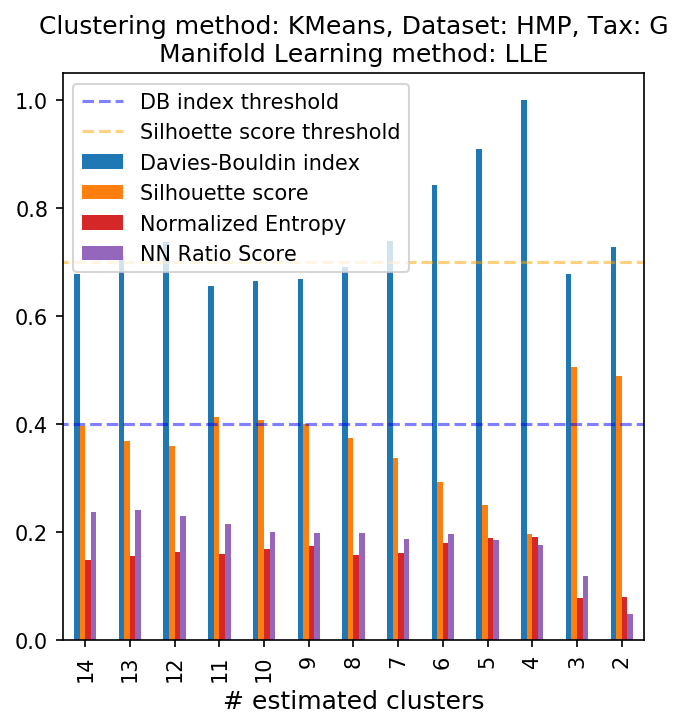

In [48]:
plot_clustering(lle_cluster_results_list[1], method='Manifold Learning method: LLE', suptitle='Clustering method: KMeans')

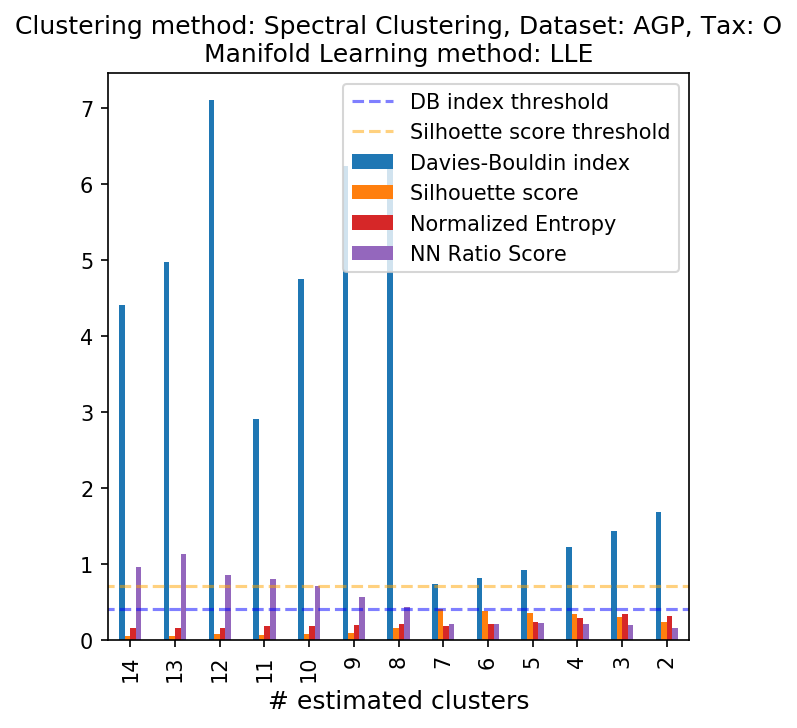

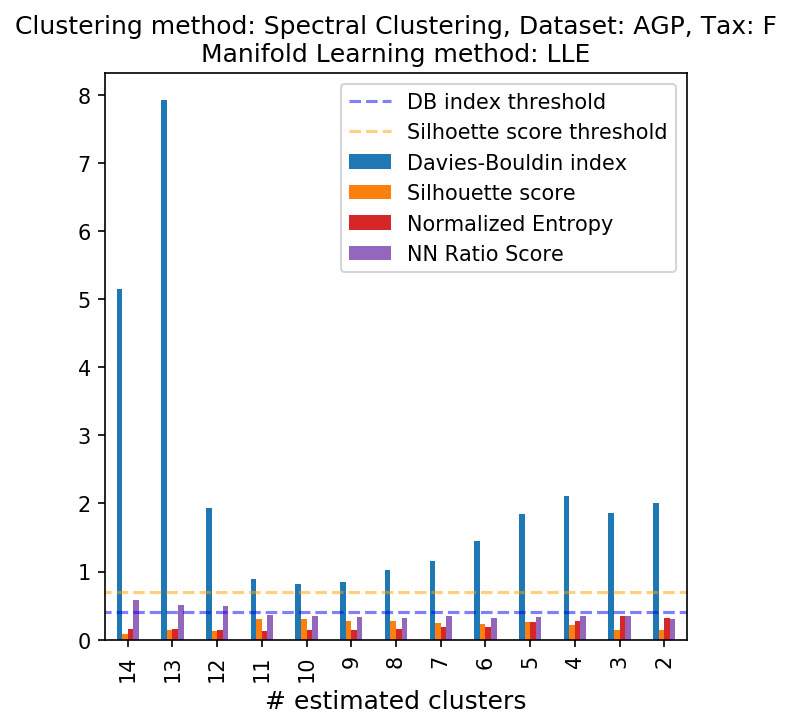

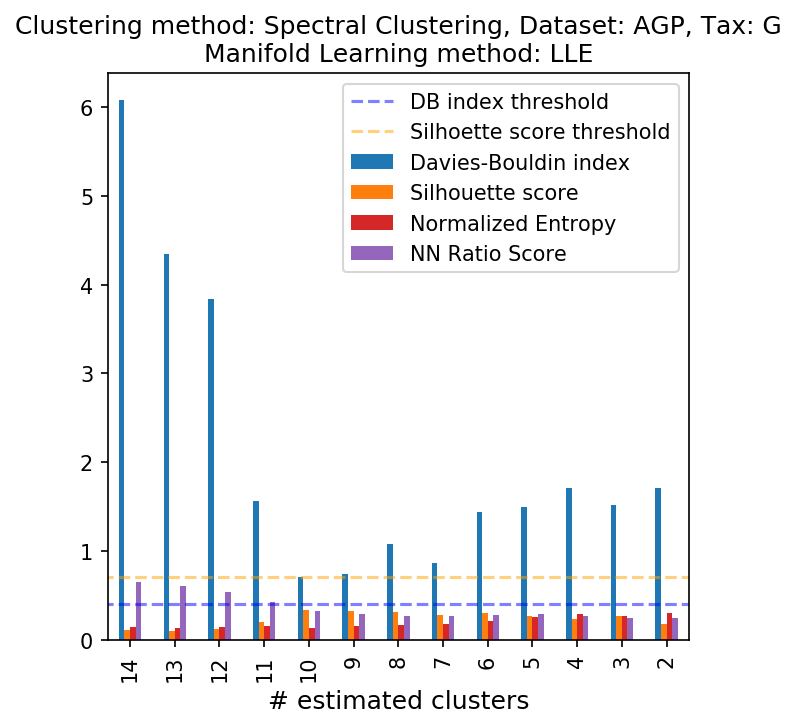

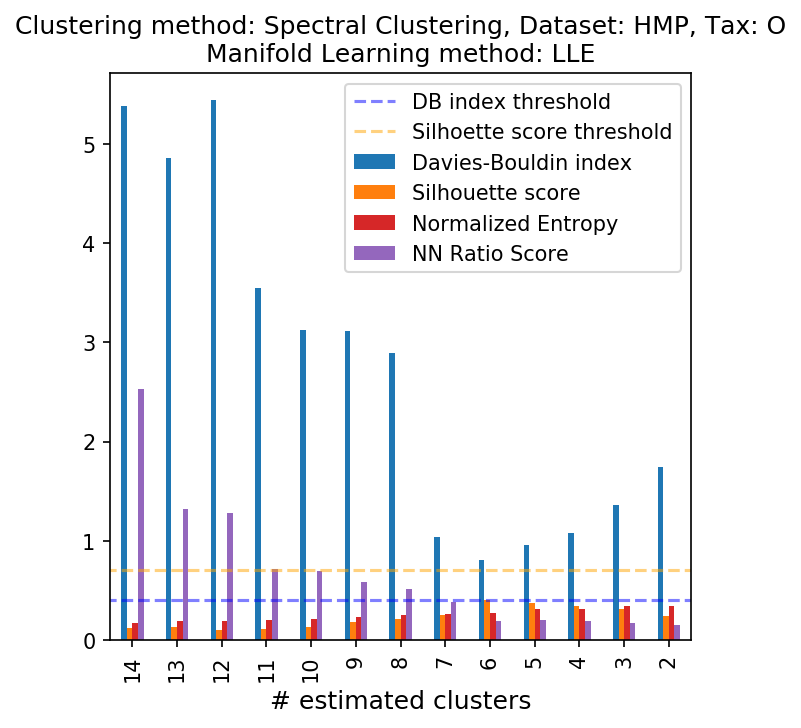

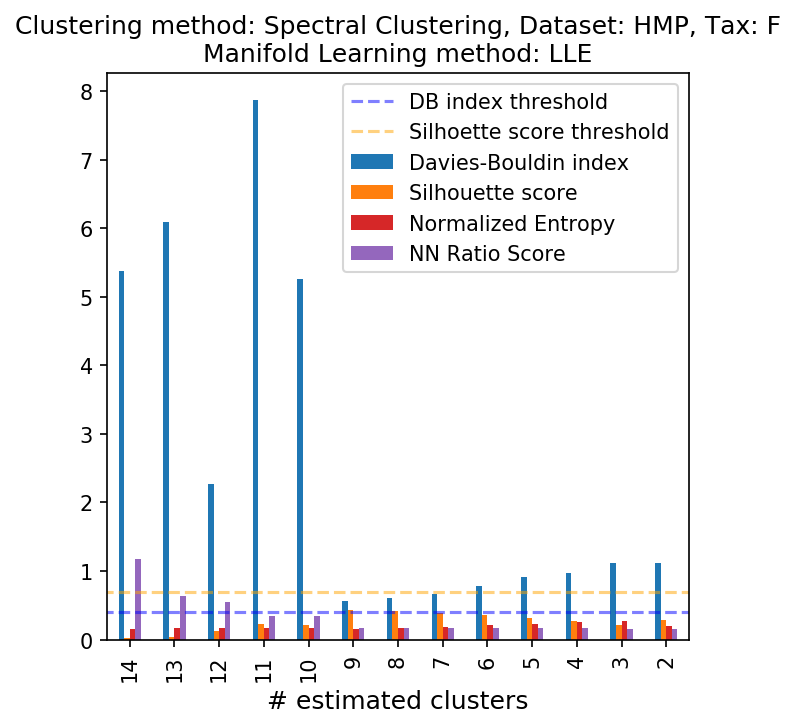

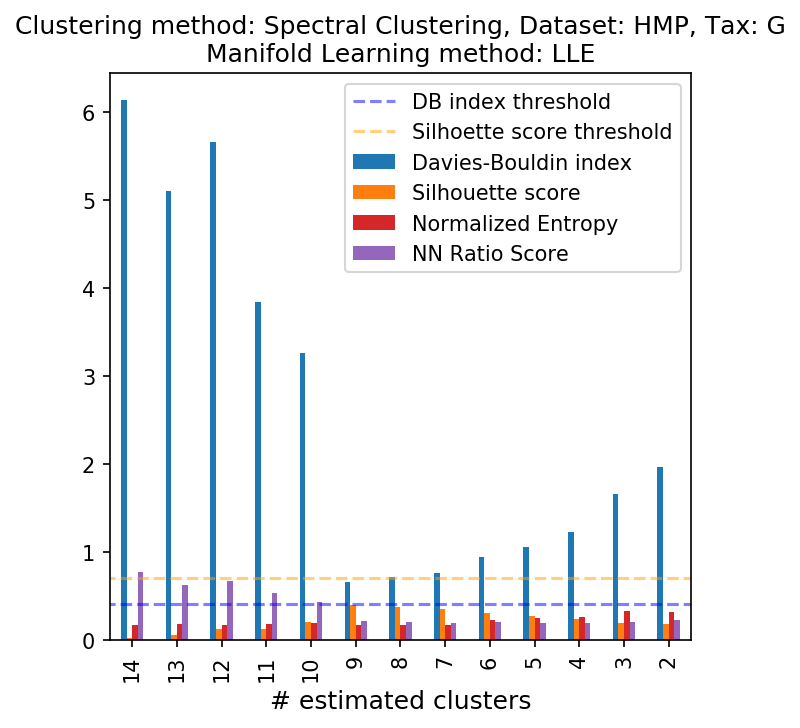

In [49]:
plot_clustering(lle_cluster_results_list[2], method='Manifold Learning method: LLE', suptitle='Clustering method: Spectral Clustering')

In [ ]:
DISTINCT_CLUSTERS_RESULTS_LLE = {'AGP_proj_f':{'KMeans':[lle_cluster_preds_list[1]['AGP_proj_f'], 3]}}
plot_results(DISTINCT_CLUSTERS_RESULTS_LLE, data_lle)

# Plot scatterplot results

In [44]:
cluster_results_all = defaultdict(list)

types = [int, float, float, float, float, str, str, str]

for mf_name, cluster_results_list in {'PCA':pca_cluster_results_list, 
                                      'AutoEncoder':ae_cluster_results_list, 
                                      'Isomap':isomap_cluster_results_list, 
                                      'LLE':lle_cluster_results_list}.items():
    for clust, cluster_results in zip(['DBSCAN', 'KMeans', 'Spectral Clustering'], cluster_results_list):
        for dataset_tax_cluster_name, dataset_tax_cluster_results in cluster_results.items():
            dataset_name, _, tax_name = dataset_tax_cluster_name.split('_')
            if dataset_name == 'ptb':
                dataset_name = 'HMP'
            for n_clusters, metrics in dataset_tax_cluster_results.items():
                cluster_results_all[dataset_name].append([n_clusters] + metrics + [tax_name.capitalize()] + [mf_name] + [clust])
                
for k,v in cluster_results_all.items():          
    df = pd.DataFrame(np.array(v), \
                       columns=['Num clusters', 
                                'Davies-Bouldin index', 
                                'Silhouette score', 
                                'Noise Ratio',
                                'Normalized Entropy',
                                'Tax Name',
                                'Mf Name',
                                'Clustering'])

    for i, c in enumerate(df.columns):
        df[c] = df[c].astype(types[i])
        
    cluster_results_all[k] = df

In [45]:
# alpha_max = 0.7
# cluster_results_all['Normalized Entropy_'] = MinMaxScaler((0,alpha_max)).fit_transform(cluster_results_all['Normalized Entropy'][:,None]).flatten()
# cluster_results_all['Normalized Entropy_'] = np.clip(cluster_results_all['Normalized Entropy_'], 0, alpha_max)

Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  F Mf:  AutoEncoder Clustering:  KMeans


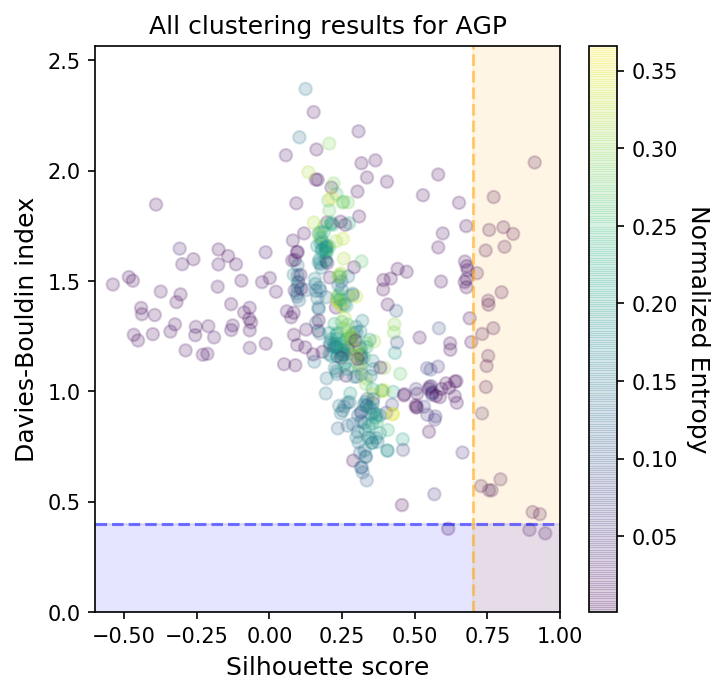

Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  F Mf:  AutoEncoder Clustering:  KMeans
Tax:  G Mf:  AutoEncoder Clustering:  KMeans


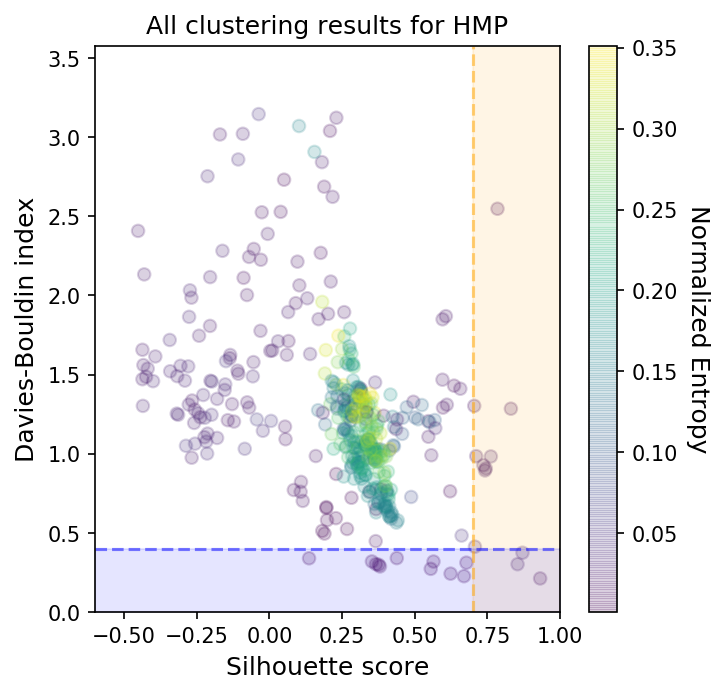

In [46]:
for k,v in cluster_results_all.items():
    plt.figure(figsize=FIGSIZE, dpi=DPI)
    # for i in range(len(cluster_results_all)): # [i]
    plt.scatter(v['Silhouette score'], 
                v['Davies-Bouldin index'],
                alpha=0.2,
                c = v['Normalized Entropy'])
    #                 color='blue')
    
    dbs, silhs = v['Davies-Bouldin index'], v['Silhouette score']
    taxs, mfs, clusts = v['Tax Name'], v['Mf Name'], v['Clustering']
    mask = (dbs < DB_THRESHOLD_DISTINCT)*(silhs > SILHOETTE_THRESHOLD_DISTINCT)
    
    taxs_ = taxs[mask].values
    mfs_ = mfs[mask].values
    clusts_ = clusts[mask].values
    
    for i in range(mask.sum()):
        print('Tax: ', taxs_[i], 'Mf: ', mfs_[i], 'Clustering: ', clusts_[i])
    
    cbar = plt.colorbar()
    cbar.set_label('Normalized Entropy', rotation=270, fontsize=FONTSIZE, labelpad=15)

    DBMAX = np.percentile(v['Davies-Bouldin index'], q=95) + 0.55
    plt.ylim(0,DBMAX)
    plt.xlim(-0.6,1)

    plt.hlines(DB_THRESHOLD_DISTINCT, -0.6, 1, linestyle='--', color='blue', alpha=0.5, label='DB index threshold')
    plt.vlines(SILHOETTE_THRESHOLD_DISTINCT, 0, DBMAX, linestyle='--', color='orange', alpha=0.5, label='Silhoette score threshold')
    plt.fill_between(x=[SILHOETTE_THRESHOLD_DISTINCT, 1], y1=0, y2=5, color='orange', alpha=0.1)
    plt.fill_between(x=[-0.6, 1], y1=0, y2=DB_THRESHOLD_DISTINCT, color='blue', alpha=0.1)
    plt.xlabel('Silhouette score',fontsize=FONTSIZE)
    plt.ylabel('Davies-Bouldin index',fontsize=FONTSIZE)
    plt.title(f'All clustering results for {k}', fontsize=FONTSIZE)
    plt.show()

In [51]:
SILHOETTE_THRESHOLD_MODERATE = 0.25
DB_THRESHOLD_MODERATE = 1

Tax:  O Mf:  PCA Clustering:  KMeans
Tax:  O Mf:  PCA Clustering:  Spectral Clustering
Tax:  O Mf:  PCA Clustering:  Spectral Clustering
Tax:  O Mf:  PCA Clustering:  Spectral Clustering
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  O Mf:  Isomap Clustering:  DBSCAN
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isom

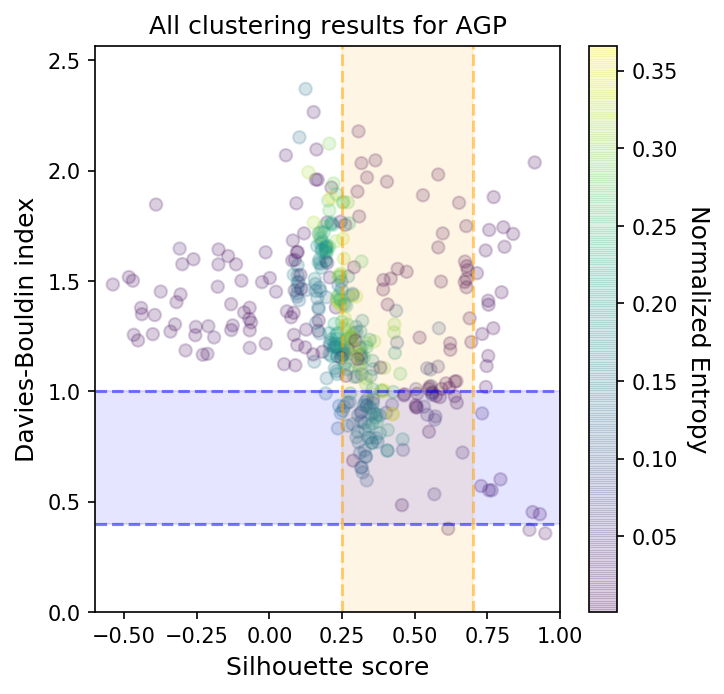

Tax:  O Mf:  PCA Clustering:  KMeans
Tax:  F Mf:  PCA Clustering:  KMeans
Tax:  O Mf:  PCA Clustering:  Spectral Clustering
Tax:  F Mf:  PCA Clustering:  Spectral Clustering
Tax:  O Mf:  AutoEncoder Clustering:  DBSCAN
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  O Mf:  AutoEncoder Clustering:  KMeans
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  F Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  G Mf:  AutoEncoder Clustering:  Spectral Clustering
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  O Mf:  Isomap Clustering:  KMeans
Tax:  F Mf:  Isomap Clustering:  KMeans
Tax:  G Mf:  Isoma

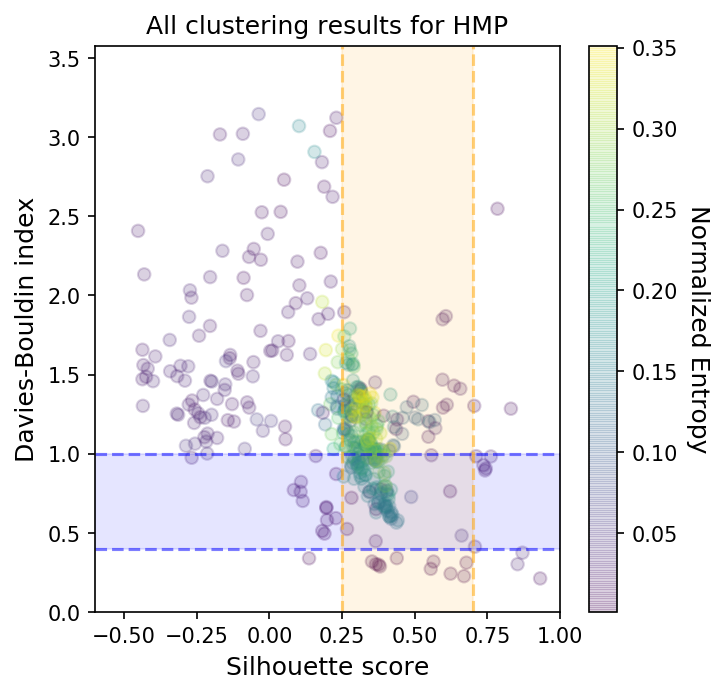

In [54]:
for k,v in cluster_results_all.items():
    plt.figure(figsize=FIGSIZE, dpi=DPI)
    # for i in range(len(cluster_results_all)): # [i]
    plt.scatter(v['Silhouette score'], 
                v['Davies-Bouldin index'],
                alpha=0.2,
                c = v['Normalized Entropy'])
    #                 color='blue')
    
    dbs, silhs = v['Davies-Bouldin index'], v['Silhouette score']
    taxs, mfs, clusts = v['Tax Name'], v['Mf Name'], v['Clustering']
    
    mask = (dbs > DB_THRESHOLD_DISTINCT)*(silhs < SILHOETTE_THRESHOLD_DISTINCT)*\
            (dbs < DB_THRESHOLD_MODERATE)*(silhs > SILHOETTE_THRESHOLD_MODERATE)
    
    taxs_ = taxs[mask].values
    mfs_ = mfs[mask].values
    clusts_ = clusts[mask].values
    
    for i in range(mask.sum()):
        print('Tax: ', taxs_[i], 'Mf: ', mfs_[i], 'Clustering: ', clusts_[i])
    
    cbar = plt.colorbar()
    cbar.set_label('Normalized Entropy', rotation=270, fontsize=FONTSIZE, labelpad=15)

    DBMAX = np.percentile(v['Davies-Bouldin index'], q=95) + 0.55
    plt.ylim(0,DBMAX)
    plt.xlim(-0.6,1)

    plt.hlines([DB_THRESHOLD_DISTINCT, DB_THRESHOLD_MODERATE], -0.6, 1, linestyle='--', color='blue', alpha=0.5, label='DB index threshold')
    plt.vlines([SILHOETTE_THRESHOLD_DISTINCT, SILHOETTE_THRESHOLD_MODERATE], 0, DBMAX, linestyle='--', color='orange', alpha=0.5, label='Silhoette score threshold')
    plt.fill_between(x=[SILHOETTE_THRESHOLD_MODERATE, SILHOETTE_THRESHOLD_DISTINCT], y1=0, y2=5, color='orange', alpha=0.1)
    plt.fill_between(x=[-0.6, 1], y1=DB_THRESHOLD_MODERATE, y2=DB_THRESHOLD_DISTINCT, color='blue', alpha=0.1)
    plt.xlabel('Silhouette score',fontsize=FONTSIZE)
    plt.ylabel('Davies-Bouldin index',fontsize=FONTSIZE)
    plt.title(f'All clustering results for {k}', fontsize=FONTSIZE)
    plt.show()